In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "2:3"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 151706 images
Dataset type val label type: species


Loaded 37931 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 55824 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 41868 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

2:3 8vaux52z


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                      | 0/1186 [00:00<?, ?it/s]

  0%|                              | 1/1186 [00:00<18:33,  1.06it/s]

  0%|                              | 2/1186 [00:01<09:37,  2.05it/s]

  0%|                              | 3/1186 [00:01<06:46,  2.91it/s]

  0%|                              | 4/1186 [00:01<05:25,  3.63it/s]

  0%|▏                             | 5/1186 [00:01<04:40,  4.20it/s]

  1%|▏                             | 6/1186 [00:01<04:13,  4.65it/s]

  1%|▏                             | 7/1186 [00:01<03:56,  4.98it/s]

  1%|▏                             | 8/1186 [00:02<03:45,  5.23it/s]

  1%|▏                             | 9/1186 [00:02<03:37,  5.41it/s]

  1%|▏                            | 10/1186 [00:02<03:32,  5.54it/s]

  1%|▎                            | 11/1186 [00:02<03:28,  5.63it/s]

  1%|▎                            | 12/1186 [00:02<03:26,  5.69it/s]

  1%|▎                            | 13/1186 [00:02<03:24,  5.74it/s]

  1%|▎                            | 14/1186 [00:03<03:22,  5.78it/s]

  1%|▎                            | 15/1186 [00:03<03:22,  5.79it/s]

  1%|▍                            | 16/1186 [00:03<03:21,  5.81it/s]

  1%|▍                            | 17/1186 [00:03<03:20,  5.82it/s]

  2%|▍                            | 18/1186 [00:03<03:20,  5.82it/s]

  2%|▍                            | 19/1186 [00:04<03:20,  5.83it/s]

  2%|▍                            | 20/1186 [00:04<03:19,  5.84it/s]

  2%|▌                            | 21/1186 [00:04<03:19,  5.84it/s]

  2%|▌                            | 22/1186 [00:04<03:19,  5.85it/s]

  2%|▌                            | 23/1186 [00:04<03:18,  5.85it/s]

  2%|▌                            | 24/1186 [00:04<03:18,  5.85it/s]

  2%|▌                            | 25/1186 [00:05<03:18,  5.85it/s]

  2%|▋                            | 26/1186 [00:05<03:18,  5.85it/s]

  2%|▋                            | 27/1186 [00:05<03:17,  5.86it/s]

  2%|▋                            | 28/1186 [00:05<03:17,  5.86it/s]

  2%|▋                            | 29/1186 [00:05<03:17,  5.86it/s]

  3%|▋                            | 30/1186 [00:05<03:17,  5.86it/s]

  3%|▊                            | 31/1186 [00:06<03:17,  5.86it/s]

  3%|▊                            | 32/1186 [00:06<03:17,  5.85it/s]

  3%|▊                            | 33/1186 [00:06<03:16,  5.86it/s]

  3%|▊                            | 34/1186 [00:06<03:16,  5.85it/s]

  3%|▊                            | 35/1186 [00:06<03:16,  5.85it/s]

  3%|▉                            | 36/1186 [00:06<03:16,  5.86it/s]

  3%|▉                            | 37/1186 [00:07<03:16,  5.85it/s]

  3%|▉                            | 38/1186 [00:07<03:16,  5.85it/s]

  3%|▉                            | 39/1186 [00:07<03:16,  5.85it/s]

  3%|▉                            | 40/1186 [00:07<03:15,  5.85it/s]

  3%|█                            | 41/1186 [00:07<03:15,  5.85it/s]

  4%|█                            | 42/1186 [00:07<03:15,  5.86it/s]

  4%|█                            | 43/1186 [00:08<03:15,  5.86it/s]

  4%|█                            | 44/1186 [00:08<03:15,  5.85it/s]

  4%|█                            | 45/1186 [00:08<03:15,  5.85it/s]

  4%|█                            | 46/1186 [00:08<03:15,  5.84it/s]

  4%|█▏                           | 47/1186 [00:08<03:14,  5.85it/s]

  4%|█▏                           | 48/1186 [00:08<03:14,  5.85it/s]

  4%|█▏                           | 49/1186 [00:09<03:14,  5.85it/s]

  4%|█▏                           | 50/1186 [00:09<03:13,  5.86it/s]

  4%|█▏                           | 51/1186 [00:09<03:13,  5.86it/s]

  4%|█▎                           | 52/1186 [00:09<03:13,  5.86it/s]

  4%|█▎                           | 53/1186 [00:09<03:13,  5.85it/s]

  5%|█▎                           | 54/1186 [00:09<03:13,  5.86it/s]

  5%|█▎                           | 55/1186 [00:10<03:13,  5.86it/s]

  5%|█▎                           | 56/1186 [00:10<03:12,  5.86it/s]

  5%|█▍                           | 57/1186 [00:10<03:12,  5.86it/s]

  5%|█▍                           | 58/1186 [00:10<03:12,  5.86it/s]

  5%|█▍                           | 59/1186 [00:10<03:12,  5.86it/s]

  5%|█▍                           | 60/1186 [00:11<03:12,  5.85it/s]

  5%|█▍                           | 61/1186 [00:11<03:12,  5.86it/s]

  5%|█▌                           | 62/1186 [00:11<03:11,  5.86it/s]

  5%|█▌                           | 63/1186 [00:11<03:11,  5.86it/s]

  5%|█▌                           | 64/1186 [00:11<03:11,  5.86it/s]

  5%|█▌                           | 65/1186 [00:11<03:11,  5.86it/s]

  6%|█▌                           | 66/1186 [00:12<03:11,  5.86it/s]

  6%|█▋                           | 67/1186 [00:12<03:11,  5.85it/s]

  6%|█▋                           | 68/1186 [00:12<03:10,  5.85it/s]

  6%|█▋                           | 69/1186 [00:12<03:10,  5.86it/s]

  6%|█▋                           | 70/1186 [00:12<03:10,  5.86it/s]

  6%|█▋                           | 71/1186 [00:12<03:10,  5.86it/s]

  6%|█▊                           | 72/1186 [00:13<03:10,  5.85it/s]

  6%|█▊                           | 73/1186 [00:13<03:10,  5.85it/s]

  6%|█▊                           | 74/1186 [00:13<03:10,  5.84it/s]

  6%|█▊                           | 75/1186 [00:13<03:09,  5.85it/s]

  6%|█▊                           | 76/1186 [00:13<03:09,  5.85it/s]

  6%|█▉                           | 77/1186 [00:13<03:09,  5.85it/s]

  7%|█▉                           | 78/1186 [00:14<03:09,  5.86it/s]

  7%|█▉                           | 79/1186 [00:14<03:09,  5.86it/s]

  7%|█▉                           | 80/1186 [00:14<03:08,  5.86it/s]

  7%|█▉                           | 81/1186 [00:14<03:08,  5.85it/s]

  7%|██                           | 82/1186 [00:14<03:08,  5.85it/s]

  7%|██                           | 83/1186 [00:14<03:08,  5.85it/s]

  7%|██                           | 84/1186 [00:15<03:08,  5.86it/s]

  7%|██                           | 85/1186 [00:15<03:07,  5.86it/s]

  7%|██                           | 86/1186 [00:15<03:07,  5.86it/s]

  7%|██▏                          | 87/1186 [00:15<03:07,  5.86it/s]

  7%|██▏                          | 88/1186 [00:15<03:07,  5.85it/s]

  8%|██▏                          | 89/1186 [00:15<03:07,  5.85it/s]

  8%|██▏                          | 90/1186 [00:16<03:07,  5.86it/s]

  8%|██▏                          | 91/1186 [00:16<03:06,  5.86it/s]

  8%|██▏                          | 92/1186 [00:16<03:06,  5.86it/s]

  8%|██▎                          | 93/1186 [00:16<03:06,  5.86it/s]

  8%|██▎                          | 94/1186 [00:16<03:06,  5.86it/s]

  8%|██▎                          | 95/1186 [00:16<03:06,  5.85it/s]

  8%|██▎                          | 96/1186 [00:17<03:06,  5.86it/s]

  8%|██▎                          | 97/1186 [00:17<03:05,  5.86it/s]

  8%|██▍                          | 98/1186 [00:17<03:05,  5.86it/s]

  8%|██▍                          | 99/1186 [00:17<03:05,  5.86it/s]

  8%|██▎                         | 100/1186 [00:17<03:05,  5.87it/s]

  9%|██▍                         | 101/1186 [00:18<03:04,  5.87it/s]

  9%|██▍                         | 102/1186 [00:18<03:04,  5.86it/s]

  9%|██▍                         | 103/1186 [00:18<03:04,  5.86it/s]

  9%|██▍                         | 104/1186 [00:18<03:04,  5.87it/s]

  9%|██▍                         | 105/1186 [00:18<03:04,  5.87it/s]

  9%|██▌                         | 106/1186 [00:18<03:04,  5.87it/s]

  9%|██▌                         | 107/1186 [00:19<03:03,  5.87it/s]

  9%|██▌                         | 108/1186 [00:19<03:03,  5.87it/s]

  9%|██▌                         | 109/1186 [00:19<03:03,  5.86it/s]

  9%|██▌                         | 110/1186 [00:19<03:03,  5.87it/s]

  9%|██▌                         | 111/1186 [00:19<03:03,  5.87it/s]

  9%|██▋                         | 112/1186 [00:19<03:02,  5.87it/s]

 10%|██▋                         | 113/1186 [00:20<03:02,  5.87it/s]

 10%|██▋                         | 114/1186 [00:20<03:02,  5.87it/s]

 10%|██▋                         | 115/1186 [00:20<03:02,  5.87it/s]

 10%|██▋                         | 116/1186 [00:20<03:02,  5.86it/s]

 10%|██▊                         | 117/1186 [00:20<03:02,  5.86it/s]

 10%|██▊                         | 118/1186 [00:20<03:02,  5.86it/s]

 10%|██▊                         | 119/1186 [00:21<03:01,  5.87it/s]

 10%|██▊                         | 120/1186 [00:21<03:01,  5.87it/s]

 10%|██▊                         | 121/1186 [00:21<03:01,  5.87it/s]

 10%|██▉                         | 122/1186 [00:21<03:01,  5.87it/s]

 10%|██▉                         | 123/1186 [00:21<03:01,  5.87it/s]

 10%|██▉                         | 124/1186 [00:21<03:00,  5.88it/s]

 11%|██▉                         | 125/1186 [00:22<03:00,  5.88it/s]

 11%|██▉                         | 126/1186 [00:22<02:59,  5.89it/s]

 11%|██▉                         | 127/1186 [00:22<02:59,  5.90it/s]

 11%|███                         | 128/1186 [00:22<02:59,  5.90it/s]

 11%|███                         | 129/1186 [00:22<02:59,  5.90it/s]

 11%|███                         | 130/1186 [00:22<02:59,  5.90it/s]

 11%|███                         | 131/1186 [00:23<02:59,  5.89it/s]

 11%|███                         | 132/1186 [00:23<02:59,  5.88it/s]

 11%|███▏                        | 133/1186 [00:23<02:59,  5.88it/s]

 11%|███▏                        | 134/1186 [00:23<02:59,  5.88it/s]

 11%|███▏                        | 135/1186 [00:23<02:58,  5.87it/s]

 11%|███▏                        | 136/1186 [00:23<02:58,  5.87it/s]

 12%|███▏                        | 137/1186 [00:24<02:58,  5.86it/s]

 12%|███▎                        | 138/1186 [00:24<02:58,  5.86it/s]

 12%|███▎                        | 139/1186 [00:24<02:58,  5.86it/s]

 12%|███▎                        | 140/1186 [00:24<02:58,  5.86it/s]

 12%|███▎                        | 141/1186 [00:24<02:58,  5.87it/s]

 12%|███▎                        | 142/1186 [00:25<02:57,  5.87it/s]

 12%|███▍                        | 143/1186 [00:25<02:57,  5.87it/s]

 12%|███▍                        | 144/1186 [00:25<02:57,  5.86it/s]

 12%|███▍                        | 145/1186 [00:25<02:57,  5.86it/s]

 12%|███▍                        | 146/1186 [00:25<02:57,  5.86it/s]

 12%|███▍                        | 147/1186 [00:25<02:57,  5.87it/s]

 12%|███▍                        | 148/1186 [00:26<02:56,  5.87it/s]

 13%|███▌                        | 149/1186 [00:26<02:56,  5.86it/s]

 13%|███▌                        | 150/1186 [00:26<02:56,  5.87it/s]

 13%|███▌                        | 151/1186 [00:26<02:56,  5.86it/s]

 13%|███▌                        | 152/1186 [00:26<02:56,  5.86it/s]

 13%|███▌                        | 153/1186 [00:26<02:56,  5.86it/s]

 13%|███▋                        | 154/1186 [00:27<02:56,  5.85it/s]

 13%|███▋                        | 155/1186 [00:27<02:56,  5.85it/s]

 13%|███▋                        | 156/1186 [00:27<02:55,  5.86it/s]

 13%|███▋                        | 157/1186 [00:27<02:55,  5.86it/s]

 13%|███▋                        | 158/1186 [00:27<02:55,  5.85it/s]

 13%|███▊                        | 159/1186 [00:27<02:55,  5.85it/s]

 13%|███▊                        | 160/1186 [00:28<02:55,  5.86it/s]

 14%|███▊                        | 161/1186 [00:28<02:54,  5.86it/s]

 14%|███▊                        | 162/1186 [00:28<02:54,  5.86it/s]

 14%|███▊                        | 163/1186 [00:28<02:54,  5.86it/s]

 14%|███▊                        | 164/1186 [00:28<02:54,  5.85it/s]

 14%|███▉                        | 165/1186 [00:28<02:54,  5.85it/s]

 14%|███▉                        | 166/1186 [00:29<02:54,  5.85it/s]

 14%|███▉                        | 167/1186 [00:29<02:53,  5.86it/s]

 14%|███▉                        | 168/1186 [00:29<02:53,  5.86it/s]

 14%|███▉                        | 169/1186 [00:29<02:53,  5.86it/s]

 14%|████                        | 170/1186 [00:29<02:53,  5.86it/s]

 14%|████                        | 171/1186 [00:29<02:53,  5.86it/s]

 15%|████                        | 172/1186 [00:30<02:53,  5.85it/s]

 15%|████                        | 173/1186 [00:30<02:52,  5.86it/s]

 15%|████                        | 174/1186 [00:30<02:52,  5.86it/s]

 15%|████▏                       | 175/1186 [00:30<02:52,  5.86it/s]

 15%|████▏                       | 176/1186 [00:30<02:52,  5.86it/s]

 15%|████▏                       | 177/1186 [00:30<02:52,  5.86it/s]

 15%|████▏                       | 178/1186 [00:31<02:51,  5.86it/s]

 15%|████▏                       | 179/1186 [00:31<02:51,  5.86it/s]

 15%|████▏                       | 180/1186 [00:31<02:51,  5.88it/s]

 15%|████▎                       | 181/1186 [00:31<02:50,  5.89it/s]

 15%|████▎                       | 182/1186 [00:31<02:50,  5.89it/s]

 15%|████▎                       | 183/1186 [00:31<02:49,  5.90it/s]

 16%|████▎                       | 184/1186 [00:32<02:49,  5.90it/s]

 16%|████▎                       | 185/1186 [00:32<02:49,  5.90it/s]

 16%|████▍                       | 186/1186 [00:32<02:49,  5.89it/s]

 16%|████▍                       | 187/1186 [00:32<02:49,  5.88it/s]

 16%|████▍                       | 188/1186 [00:32<02:49,  5.87it/s]

 16%|████▍                       | 189/1186 [00:33<02:49,  5.87it/s]

 16%|████▍                       | 190/1186 [00:33<02:49,  5.87it/s]

 16%|████▌                       | 191/1186 [00:33<02:49,  5.87it/s]

 16%|████▌                       | 192/1186 [00:33<02:49,  5.87it/s]

 16%|████▌                       | 193/1186 [00:33<02:49,  5.86it/s]

 16%|████▌                       | 194/1186 [00:33<02:49,  5.86it/s]

 16%|████▌                       | 195/1186 [00:34<02:49,  5.86it/s]

 17%|████▋                       | 196/1186 [00:34<02:48,  5.86it/s]

 17%|████▋                       | 197/1186 [00:34<02:48,  5.86it/s]

 17%|████▋                       | 198/1186 [00:34<02:48,  5.86it/s]

 17%|████▋                       | 199/1186 [00:34<02:48,  5.86it/s]

 17%|████▋                       | 200/1186 [00:34<02:48,  5.85it/s]

 17%|████▋                       | 201/1186 [00:35<02:48,  5.85it/s]

 17%|████▊                       | 202/1186 [00:35<02:48,  5.86it/s]

 17%|████▊                       | 203/1186 [00:35<02:47,  5.86it/s]

 17%|████▊                       | 204/1186 [00:35<02:47,  5.86it/s]

 17%|████▊                       | 205/1186 [00:35<02:47,  5.86it/s]

 17%|████▊                       | 206/1186 [00:35<02:47,  5.87it/s]

 17%|████▉                       | 207/1186 [00:36<02:47,  5.86it/s]

 18%|████▉                       | 208/1186 [00:36<02:46,  5.86it/s]

 18%|████▉                       | 209/1186 [00:36<02:46,  5.87it/s]

 18%|████▉                       | 210/1186 [00:36<02:46,  5.87it/s]

 18%|████▉                       | 211/1186 [00:36<02:46,  5.87it/s]

 18%|█████                       | 212/1186 [00:36<02:46,  5.87it/s]

 18%|█████                       | 213/1186 [00:37<02:45,  5.87it/s]

 18%|█████                       | 214/1186 [00:37<02:45,  5.86it/s]

 18%|█████                       | 215/1186 [00:37<02:45,  5.86it/s]

 18%|█████                       | 216/1186 [00:37<02:45,  5.86it/s]

 18%|█████                       | 217/1186 [00:37<02:45,  5.86it/s]

 18%|█████▏                      | 218/1186 [00:37<02:45,  5.86it/s]

 18%|█████▏                      | 219/1186 [00:38<02:45,  5.86it/s]

 19%|█████▏                      | 220/1186 [00:38<02:44,  5.86it/s]

 19%|█████▏                      | 221/1186 [00:38<02:45,  5.85it/s]

 19%|█████▏                      | 222/1186 [00:38<02:44,  5.85it/s]

 19%|█████▎                      | 223/1186 [00:38<02:44,  5.85it/s]

 19%|█████▎                      | 224/1186 [00:38<02:44,  5.86it/s]

 19%|█████▎                      | 225/1186 [00:39<02:44,  5.86it/s]

 19%|█████▎                      | 226/1186 [00:39<02:43,  5.86it/s]

 19%|█████▎                      | 227/1186 [00:39<02:43,  5.86it/s]

 19%|█████▍                      | 228/1186 [00:39<02:43,  5.85it/s]

 19%|█████▍                      | 229/1186 [00:39<02:43,  5.86it/s]

 19%|█████▍                      | 230/1186 [00:40<02:43,  5.86it/s]

 19%|█████▍                      | 231/1186 [00:40<02:42,  5.86it/s]

 20%|█████▍                      | 232/1186 [00:40<02:42,  5.86it/s]

 20%|█████▌                      | 233/1186 [00:40<02:42,  5.87it/s]

 20%|█████▌                      | 234/1186 [00:40<02:42,  5.87it/s]

 20%|█████▌                      | 235/1186 [00:40<02:41,  5.87it/s]

 20%|█████▌                      | 236/1186 [00:41<02:41,  5.88it/s]

 20%|█████▌                      | 237/1186 [00:41<02:41,  5.89it/s]

 20%|█████▌                      | 238/1186 [00:41<02:40,  5.90it/s]

 20%|█████▋                      | 239/1186 [00:41<02:40,  5.90it/s]

 20%|█████▋                      | 240/1186 [00:41<02:40,  5.91it/s]

 20%|█████▋                      | 241/1186 [00:41<02:40,  5.91it/s]

 20%|█████▋                      | 242/1186 [00:42<02:40,  5.89it/s]

 20%|█████▋                      | 243/1186 [00:42<02:40,  5.88it/s]

 21%|█████▊                      | 244/1186 [00:42<02:40,  5.88it/s]

 21%|█████▊                      | 245/1186 [00:42<02:40,  5.87it/s]

 21%|█████▊                      | 246/1186 [00:42<02:40,  5.87it/s]

 21%|█████▊                      | 247/1186 [00:42<02:39,  5.87it/s]

 21%|█████▊                      | 248/1186 [00:43<02:39,  5.87it/s]

 21%|█████▉                      | 249/1186 [00:43<02:39,  5.86it/s]

 21%|█████▉                      | 250/1186 [00:43<02:39,  5.86it/s]

 21%|█████▉                      | 251/1186 [00:43<02:39,  5.86it/s]

 21%|█████▉                      | 252/1186 [00:43<02:39,  5.86it/s]

 21%|█████▉                      | 253/1186 [00:43<02:39,  5.85it/s]

 21%|█████▉                      | 254/1186 [00:44<02:39,  5.85it/s]

 22%|██████                      | 255/1186 [00:44<02:38,  5.86it/s]

 22%|██████                      | 256/1186 [00:44<02:38,  5.87it/s]

 22%|██████                      | 257/1186 [00:44<02:38,  5.87it/s]

 22%|██████                      | 258/1186 [00:44<02:38,  5.86it/s]

 22%|██████                      | 259/1186 [00:44<02:38,  5.86it/s]

 22%|██████▏                     | 260/1186 [00:45<02:37,  5.87it/s]

 22%|██████▏                     | 261/1186 [00:45<02:37,  5.87it/s]

 22%|██████▏                     | 262/1186 [00:45<02:37,  5.87it/s]

 22%|██████▏                     | 263/1186 [00:45<02:37,  5.87it/s]

 22%|██████▏                     | 264/1186 [00:45<02:37,  5.87it/s]

 22%|██████▎                     | 265/1186 [00:45<02:37,  5.86it/s]

 22%|██████▎                     | 266/1186 [00:46<02:37,  5.86it/s]

 23%|██████▎                     | 267/1186 [00:46<02:36,  5.86it/s]

 23%|██████▎                     | 268/1186 [00:46<02:36,  5.86it/s]

 23%|██████▎                     | 269/1186 [00:46<02:36,  5.86it/s]

 23%|██████▎                     | 270/1186 [00:46<02:36,  5.86it/s]

 23%|██████▍                     | 271/1186 [00:46<02:36,  5.86it/s]

 23%|██████▍                     | 272/1186 [00:47<02:36,  5.86it/s]

 23%|██████▍                     | 273/1186 [00:47<02:35,  5.86it/s]

 23%|██████▍                     | 274/1186 [00:47<02:35,  5.86it/s]

 23%|██████▍                     | 275/1186 [00:47<02:35,  5.86it/s]

 23%|██████▌                     | 276/1186 [00:47<02:35,  5.86it/s]

 23%|██████▌                     | 277/1186 [00:48<02:34,  5.87it/s]

 23%|██████▌                     | 278/1186 [00:48<02:34,  5.87it/s]

 24%|██████▌                     | 279/1186 [00:48<02:34,  5.86it/s]

 24%|██████▌                     | 280/1186 [00:48<02:34,  5.86it/s]

 24%|██████▋                     | 281/1186 [00:48<02:34,  5.86it/s]

 24%|██████▋                     | 282/1186 [00:48<02:34,  5.86it/s]

 24%|██████▋                     | 283/1186 [00:49<02:33,  5.87it/s]

 24%|██████▋                     | 284/1186 [00:49<02:33,  5.87it/s]

 24%|██████▋                     | 285/1186 [00:49<02:33,  5.86it/s]

 24%|██████▊                     | 286/1186 [00:49<02:33,  5.88it/s]

 24%|██████▊                     | 287/1186 [00:49<02:32,  5.89it/s]

 24%|██████▊                     | 288/1186 [00:49<02:32,  5.90it/s]

 24%|██████▊                     | 289/1186 [00:50<02:31,  5.90it/s]

 24%|██████▊                     | 290/1186 [00:50<02:31,  5.91it/s]

 25%|██████▊                     | 291/1186 [00:50<02:31,  5.91it/s]

 25%|██████▉                     | 292/1186 [00:50<02:31,  5.90it/s]

 25%|██████▉                     | 293/1186 [00:50<02:31,  5.89it/s]

 25%|██████▉                     | 294/1186 [00:50<02:31,  5.88it/s]

 25%|██████▉                     | 295/1186 [00:51<02:31,  5.88it/s]

 25%|██████▉                     | 296/1186 [00:51<02:31,  5.88it/s]

 25%|███████                     | 297/1186 [00:51<02:31,  5.87it/s]

 25%|███████                     | 298/1186 [00:51<02:31,  5.87it/s]

 25%|███████                     | 299/1186 [00:51<02:31,  5.86it/s]

 25%|███████                     | 300/1186 [00:51<02:31,  5.86it/s]

 25%|███████                     | 301/1186 [00:52<02:31,  5.86it/s]

 25%|███████▏                    | 302/1186 [00:52<02:30,  5.86it/s]

 26%|███████▏                    | 303/1186 [00:52<02:30,  5.86it/s]

 26%|███████▏                    | 304/1186 [00:52<02:30,  5.85it/s]

 26%|███████▏                    | 305/1186 [00:52<02:30,  5.85it/s]

 26%|███████▏                    | 306/1186 [00:52<02:30,  5.85it/s]

 26%|███████▏                    | 307/1186 [00:53<02:30,  5.85it/s]

 26%|███████▎                    | 308/1186 [00:53<02:30,  5.85it/s]

 26%|███████▎                    | 309/1186 [00:53<02:29,  5.85it/s]

 26%|███████▎                    | 310/1186 [00:53<02:29,  5.85it/s]

 26%|███████▎                    | 311/1186 [00:53<02:29,  5.86it/s]

 26%|███████▎                    | 312/1186 [00:53<02:29,  5.86it/s]

 26%|███████▍                    | 313/1186 [00:54<02:29,  5.84it/s]

 26%|███████▍                    | 314/1186 [00:54<02:29,  5.84it/s]

 27%|███████▍                    | 315/1186 [00:54<02:29,  5.84it/s]

 27%|███████▍                    | 316/1186 [00:54<02:28,  5.84it/s]

 27%|███████▍                    | 317/1186 [00:54<02:28,  5.83it/s]

 27%|███████▌                    | 318/1186 [00:55<02:28,  5.83it/s]

 27%|███████▌                    | 319/1186 [00:55<02:28,  5.84it/s]

 27%|███████▌                    | 320/1186 [00:55<02:28,  5.84it/s]

 27%|███████▌                    | 321/1186 [00:55<02:28,  5.84it/s]

 27%|███████▌                    | 322/1186 [00:55<02:27,  5.84it/s]

 27%|███████▋                    | 323/1186 [00:55<02:27,  5.84it/s]

 27%|███████▋                    | 324/1186 [00:56<02:27,  5.85it/s]

 27%|███████▋                    | 325/1186 [00:56<02:27,  5.85it/s]

 27%|███████▋                    | 326/1186 [00:56<02:26,  5.85it/s]

 28%|███████▋                    | 327/1186 [00:56<02:26,  5.85it/s]

 28%|███████▋                    | 328/1186 [00:56<02:26,  5.85it/s]

 28%|███████▊                    | 329/1186 [00:56<02:26,  5.85it/s]

 28%|███████▊                    | 330/1186 [00:57<02:26,  5.85it/s]

 28%|███████▊                    | 331/1186 [00:57<02:26,  5.85it/s]

 28%|███████▊                    | 332/1186 [00:57<02:25,  5.85it/s]

 28%|███████▊                    | 333/1186 [00:57<02:25,  5.85it/s]

 28%|███████▉                    | 334/1186 [00:57<02:25,  5.85it/s]

 28%|███████▉                    | 335/1186 [00:57<02:25,  5.85it/s]

 28%|███████▉                    | 336/1186 [00:58<02:25,  5.85it/s]

 28%|███████▉                    | 337/1186 [00:58<02:25,  5.85it/s]

 28%|███████▉                    | 338/1186 [00:58<02:25,  5.84it/s]

 29%|████████                    | 339/1186 [00:58<02:24,  5.84it/s]

 29%|████████                    | 340/1186 [00:58<02:24,  5.85it/s]

 29%|████████                    | 341/1186 [00:58<02:24,  5.85it/s]

 29%|████████                    | 342/1186 [00:59<02:24,  5.85it/s]

 29%|████████                    | 343/1186 [00:59<02:24,  5.85it/s]

 29%|████████                    | 344/1186 [00:59<02:24,  5.85it/s]

 29%|████████▏                   | 345/1186 [00:59<02:23,  5.84it/s]

 29%|████████▏                   | 346/1186 [00:59<02:23,  5.84it/s]

 29%|████████▏                   | 347/1186 [00:59<02:23,  5.84it/s]

 29%|████████▏                   | 348/1186 [01:00<02:23,  5.84it/s]

 29%|████████▏                   | 349/1186 [01:00<02:23,  5.84it/s]

 30%|████████▎                   | 350/1186 [01:00<02:23,  5.84it/s]

 30%|████████▎                   | 351/1186 [01:00<02:22,  5.84it/s]

 30%|████████▎                   | 352/1186 [01:00<02:22,  5.85it/s]

 30%|████████▎                   | 353/1186 [01:01<02:22,  5.85it/s]

 30%|████████▎                   | 354/1186 [01:01<02:22,  5.85it/s]

 30%|████████▍                   | 355/1186 [01:01<02:22,  5.85it/s]

 30%|████████▍                   | 356/1186 [01:01<02:21,  5.85it/s]

 30%|████████▍                   | 357/1186 [01:01<02:21,  5.85it/s]

 30%|████████▍                   | 358/1186 [01:01<02:21,  5.85it/s]

 30%|████████▍                   | 359/1186 [01:02<02:21,  5.85it/s]

 30%|████████▍                   | 360/1186 [01:02<02:21,  5.85it/s]

 30%|████████▌                   | 361/1186 [01:02<02:20,  5.85it/s]

 31%|████████▌                   | 362/1186 [01:02<02:20,  5.86it/s]

 31%|████████▌                   | 363/1186 [01:02<02:20,  5.86it/s]

 31%|████████▌                   | 364/1186 [01:02<02:20,  5.86it/s]

 31%|████████▌                   | 365/1186 [01:03<02:20,  5.86it/s]

 31%|████████▋                   | 366/1186 [01:03<02:20,  5.86it/s]

 31%|████████▋                   | 367/1186 [01:03<02:19,  5.85it/s]

 31%|████████▋                   | 368/1186 [01:03<02:19,  5.85it/s]

 31%|████████▋                   | 369/1186 [01:03<02:19,  5.85it/s]

 31%|████████▋                   | 370/1186 [01:03<02:19,  5.84it/s]

 31%|████████▊                   | 371/1186 [01:04<02:20,  5.82it/s]

 31%|████████▊                   | 372/1186 [01:04<02:19,  5.83it/s]

 31%|████████▊                   | 373/1186 [01:04<02:19,  5.83it/s]

 32%|████████▊                   | 374/1186 [01:04<02:19,  5.84it/s]

 32%|████████▊                   | 375/1186 [01:04<02:18,  5.84it/s]

 32%|████████▉                   | 376/1186 [01:04<02:18,  5.85it/s]

 32%|████████▉                   | 377/1186 [01:05<02:18,  5.85it/s]

 32%|████████▉                   | 378/1186 [01:05<02:18,  5.85it/s]

 32%|████████▉                   | 379/1186 [01:05<02:17,  5.86it/s]

 32%|████████▉                   | 380/1186 [01:05<02:17,  5.86it/s]

 32%|████████▉                   | 381/1186 [01:05<02:17,  5.86it/s]

 32%|█████████                   | 382/1186 [01:05<02:17,  5.86it/s]

 32%|█████████                   | 383/1186 [01:06<02:17,  5.86it/s]

 32%|█████████                   | 384/1186 [01:06<02:16,  5.86it/s]

 32%|█████████                   | 385/1186 [01:06<02:16,  5.86it/s]

 33%|█████████                   | 386/1186 [01:06<02:16,  5.86it/s]

 33%|█████████▏                  | 387/1186 [01:06<02:16,  5.86it/s]

 33%|█████████▏                  | 388/1186 [01:06<02:16,  5.86it/s]

 33%|█████████▏                  | 389/1186 [01:07<02:16,  5.85it/s]

 33%|█████████▏                  | 390/1186 [01:07<02:16,  5.85it/s]

 33%|█████████▏                  | 391/1186 [01:07<02:15,  5.85it/s]

 33%|█████████▎                  | 392/1186 [01:07<02:15,  5.86it/s]

 33%|█████████▎                  | 393/1186 [01:07<02:15,  5.85it/s]

 33%|█████████▎                  | 394/1186 [01:08<02:15,  5.85it/s]

 33%|█████████▎                  | 395/1186 [01:08<02:15,  5.84it/s]

 33%|█████████▎                  | 396/1186 [01:08<02:15,  5.84it/s]

 33%|█████████▎                  | 397/1186 [01:08<02:15,  5.84it/s]

 34%|█████████▍                  | 398/1186 [01:08<02:14,  5.84it/s]

 34%|█████████▍                  | 399/1186 [01:08<02:14,  5.85it/s]

 34%|█████████▍                  | 400/1186 [01:09<02:14,  5.85it/s]

 34%|█████████▍                  | 401/1186 [01:09<02:14,  5.85it/s]

 34%|█████████▍                  | 402/1186 [01:09<02:14,  5.85it/s]

 34%|█████████▌                  | 403/1186 [01:09<02:13,  5.85it/s]

 34%|█████████▌                  | 404/1186 [01:09<02:13,  5.85it/s]

 34%|█████████▌                  | 405/1186 [01:09<02:13,  5.85it/s]

 34%|█████████▌                  | 406/1186 [01:10<02:13,  5.83it/s]

 34%|█████████▌                  | 407/1186 [01:10<02:13,  5.83it/s]

 34%|█████████▋                  | 408/1186 [01:10<02:13,  5.84it/s]

 34%|█████████▋                  | 409/1186 [01:10<02:13,  5.84it/s]

 35%|█████████▋                  | 410/1186 [01:10<02:12,  5.84it/s]

 35%|█████████▋                  | 411/1186 [01:10<02:12,  5.84it/s]

 35%|█████████▋                  | 412/1186 [01:11<02:12,  5.82it/s]

 35%|█████████▊                  | 413/1186 [01:11<02:12,  5.83it/s]

 35%|█████████▊                  | 414/1186 [01:11<02:12,  5.84it/s]

 35%|█████████▊                  | 415/1186 [01:11<02:11,  5.84it/s]

 35%|█████████▊                  | 416/1186 [01:11<02:11,  5.85it/s]

 35%|█████████▊                  | 417/1186 [01:11<02:11,  5.85it/s]

 35%|█████████▊                  | 418/1186 [01:12<02:11,  5.85it/s]

 35%|█████████▉                  | 419/1186 [01:12<02:11,  5.85it/s]

 35%|█████████▉                  | 420/1186 [01:12<02:11,  5.85it/s]

 35%|█████████▉                  | 421/1186 [01:12<02:10,  5.84it/s]

 36%|█████████▉                  | 422/1186 [01:12<02:10,  5.85it/s]

 36%|█████████▉                  | 423/1186 [01:12<02:10,  5.84it/s]

 36%|██████████                  | 424/1186 [01:13<02:10,  5.84it/s]

 36%|██████████                  | 425/1186 [01:13<02:10,  5.84it/s]

 36%|██████████                  | 426/1186 [01:13<02:10,  5.84it/s]

 36%|██████████                  | 427/1186 [01:13<02:09,  5.85it/s]

 36%|██████████                  | 428/1186 [01:13<02:09,  5.85it/s]

 36%|██████████▏                 | 429/1186 [01:13<02:09,  5.85it/s]

 36%|██████████▏                 | 430/1186 [01:14<02:09,  5.84it/s]

 36%|██████████▏                 | 431/1186 [01:14<02:09,  5.84it/s]

 36%|██████████▏                 | 432/1186 [01:14<02:08,  5.85it/s]

 37%|██████████▏                 | 433/1186 [01:14<02:08,  5.85it/s]

 37%|██████████▏                 | 434/1186 [01:14<02:08,  5.85it/s]

 37%|██████████▎                 | 435/1186 [01:15<02:08,  5.85it/s]

 37%|██████████▎                 | 436/1186 [01:15<02:08,  5.85it/s]

 37%|██████████▎                 | 437/1186 [01:15<02:08,  5.85it/s]

 37%|██████████▎                 | 438/1186 [01:15<02:07,  5.85it/s]

 37%|██████████▎                 | 439/1186 [01:15<02:07,  5.85it/s]

 37%|██████████▍                 | 440/1186 [01:15<02:07,  5.85it/s]

 37%|██████████▍                 | 441/1186 [01:16<02:07,  5.85it/s]

 37%|██████████▍                 | 442/1186 [01:16<02:07,  5.85it/s]

 37%|██████████▍                 | 443/1186 [01:16<02:06,  5.85it/s]

 37%|██████████▍                 | 444/1186 [01:16<02:06,  5.85it/s]

 38%|██████████▌                 | 445/1186 [01:16<02:06,  5.86it/s]

 38%|██████████▌                 | 446/1186 [01:16<02:06,  5.86it/s]

 38%|██████████▌                 | 447/1186 [01:17<02:06,  5.85it/s]

 38%|██████████▌                 | 448/1186 [01:17<02:06,  5.86it/s]

 38%|██████████▌                 | 449/1186 [01:17<02:05,  5.86it/s]

 38%|██████████▌                 | 450/1186 [01:17<02:05,  5.86it/s]

 38%|██████████▋                 | 451/1186 [01:17<02:05,  5.86it/s]

 38%|██████████▋                 | 452/1186 [01:17<02:05,  5.86it/s]

 38%|██████████▋                 | 453/1186 [01:18<02:05,  5.85it/s]

 38%|██████████▋                 | 454/1186 [01:18<02:05,  5.85it/s]

 38%|██████████▋                 | 455/1186 [01:18<02:04,  5.86it/s]

 38%|██████████▊                 | 456/1186 [01:18<02:04,  5.86it/s]

 39%|██████████▊                 | 457/1186 [01:18<02:04,  5.85it/s]

 39%|██████████▊                 | 458/1186 [01:18<02:04,  5.86it/s]

 39%|██████████▊                 | 459/1186 [01:19<02:04,  5.86it/s]

 39%|██████████▊                 | 460/1186 [01:19<02:03,  5.86it/s]

 39%|██████████▉                 | 461/1186 [01:19<02:03,  5.86it/s]

 39%|██████████▉                 | 462/1186 [01:19<02:03,  5.86it/s]

 39%|██████████▉                 | 463/1186 [01:19<02:03,  5.86it/s]

 39%|██████████▉                 | 464/1186 [01:19<02:03,  5.86it/s]

 39%|██████████▉                 | 465/1186 [01:20<02:03,  5.86it/s]

 39%|███████████                 | 466/1186 [01:20<02:02,  5.86it/s]

 39%|███████████                 | 467/1186 [01:20<02:02,  5.85it/s]

 39%|███████████                 | 468/1186 [01:20<02:02,  5.85it/s]

 40%|███████████                 | 469/1186 [01:20<02:02,  5.85it/s]

 40%|███████████                 | 470/1186 [01:21<02:02,  5.85it/s]

 40%|███████████                 | 471/1186 [01:21<02:02,  5.85it/s]

 40%|███████████▏                | 472/1186 [01:21<02:02,  5.85it/s]

 40%|███████████▏                | 473/1186 [01:21<02:01,  5.85it/s]

 40%|███████████▏                | 474/1186 [01:21<02:01,  5.85it/s]

 40%|███████████▏                | 475/1186 [01:21<02:01,  5.85it/s]

 40%|███████████▏                | 476/1186 [01:22<02:01,  5.85it/s]

 40%|███████████▎                | 477/1186 [01:22<02:01,  5.85it/s]

 40%|███████████▎                | 478/1186 [01:22<02:00,  5.85it/s]

 40%|███████████▎                | 479/1186 [01:22<02:00,  5.85it/s]

 40%|███████████▎                | 480/1186 [01:22<02:00,  5.85it/s]

 41%|███████████▎                | 481/1186 [01:22<02:00,  5.85it/s]

 41%|███████████▍                | 482/1186 [01:23<02:00,  5.86it/s]

 41%|███████████▍                | 483/1186 [01:23<02:00,  5.86it/s]

 41%|███████████▍                | 484/1186 [01:23<01:59,  5.86it/s]

 41%|███████████▍                | 485/1186 [01:23<01:59,  5.86it/s]

 41%|███████████▍                | 486/1186 [01:23<01:59,  5.85it/s]

 41%|███████████▍                | 487/1186 [01:23<01:59,  5.86it/s]

 41%|███████████▌                | 488/1186 [01:24<01:59,  5.86it/s]

 41%|███████████▌                | 489/1186 [01:24<01:59,  5.86it/s]

 41%|███████████▌                | 490/1186 [01:24<01:58,  5.85it/s]

 41%|███████████▌                | 491/1186 [01:24<01:58,  5.86it/s]

 41%|███████████▌                | 492/1186 [01:24<01:58,  5.85it/s]

 42%|███████████▋                | 493/1186 [01:24<01:58,  5.85it/s]

 42%|███████████▋                | 494/1186 [01:25<01:58,  5.85it/s]

 42%|███████████▋                | 495/1186 [01:25<01:58,  5.85it/s]

 42%|███████████▋                | 496/1186 [01:25<01:57,  5.85it/s]

 42%|███████████▋                | 497/1186 [01:25<01:57,  5.85it/s]

 42%|███████████▊                | 498/1186 [01:25<01:57,  5.86it/s]

 42%|███████████▊                | 499/1186 [01:25<01:57,  5.85it/s]

 42%|███████████▊                | 500/1186 [01:26<01:57,  5.86it/s]

 42%|███████████▊                | 501/1186 [01:26<01:56,  5.86it/s]

 42%|███████████▊                | 502/1186 [01:26<01:56,  5.86it/s]

 42%|███████████▉                | 503/1186 [01:26<01:56,  5.86it/s]

 42%|███████████▉                | 504/1186 [01:26<01:56,  5.85it/s]

 43%|███████████▉                | 505/1186 [01:26<01:56,  5.85it/s]

 43%|███████████▉                | 506/1186 [01:27<01:56,  5.85it/s]

 43%|███████████▉                | 507/1186 [01:27<01:56,  5.85it/s]

 43%|███████████▉                | 508/1186 [01:27<01:55,  5.85it/s]

 43%|████████████                | 509/1186 [01:27<01:55,  5.85it/s]

 43%|████████████                | 510/1186 [01:27<01:55,  5.85it/s]

 43%|████████████                | 511/1186 [01:28<01:55,  5.85it/s]

 43%|████████████                | 512/1186 [01:28<01:55,  5.85it/s]

 43%|████████████                | 513/1186 [01:28<01:54,  5.85it/s]

 43%|████████████▏               | 514/1186 [01:28<01:54,  5.86it/s]

 43%|████████████▏               | 515/1186 [01:28<01:54,  5.86it/s]

 44%|████████████▏               | 516/1186 [01:28<01:54,  5.86it/s]

 44%|████████████▏               | 517/1186 [01:29<01:54,  5.86it/s]

 44%|████████████▏               | 518/1186 [01:29<01:54,  5.86it/s]

 44%|████████████▎               | 519/1186 [01:29<01:53,  5.86it/s]

 44%|████████████▎               | 520/1186 [01:29<01:53,  5.86it/s]

 44%|████████████▎               | 521/1186 [01:29<01:53,  5.86it/s]

 44%|████████████▎               | 522/1186 [01:29<01:53,  5.86it/s]

 44%|████████████▎               | 523/1186 [01:30<01:53,  5.86it/s]

 44%|████████████▎               | 524/1186 [01:30<01:53,  5.85it/s]

 44%|████████████▍               | 525/1186 [01:30<01:52,  5.85it/s]

 44%|████████████▍               | 526/1186 [01:30<01:52,  5.85it/s]

 44%|████████████▍               | 527/1186 [01:30<01:52,  5.85it/s]

 45%|████████████▍               | 528/1186 [01:30<01:52,  5.85it/s]

 45%|████████████▍               | 529/1186 [01:31<01:52,  5.84it/s]

 45%|████████████▌               | 530/1186 [01:31<01:52,  5.84it/s]

 45%|████████████▌               | 531/1186 [01:31<01:52,  5.85it/s]

 45%|████████████▌               | 532/1186 [01:31<01:51,  5.85it/s]

 45%|████████████▌               | 533/1186 [01:31<01:51,  5.85it/s]

 45%|████████████▌               | 534/1186 [01:31<01:51,  5.85it/s]

 45%|████████████▋               | 535/1186 [01:32<01:51,  5.85it/s]

 45%|████████████▋               | 536/1186 [01:32<01:51,  5.85it/s]

 45%|████████████▋               | 537/1186 [01:32<01:50,  5.85it/s]

 45%|████████████▋               | 538/1186 [01:32<01:50,  5.85it/s]

 45%|████████████▋               | 539/1186 [01:32<01:50,  5.85it/s]

 46%|████████████▋               | 540/1186 [01:32<01:50,  5.85it/s]

 46%|████████████▊               | 541/1186 [01:33<01:50,  5.86it/s]

 46%|████████████▊               | 542/1186 [01:33<01:49,  5.86it/s]

 46%|████████████▊               | 543/1186 [01:33<01:49,  5.86it/s]

 46%|████████████▊               | 544/1186 [01:33<01:49,  5.86it/s]

 46%|████████████▊               | 545/1186 [01:33<01:49,  5.86it/s]

 46%|████████████▉               | 546/1186 [01:33<01:49,  5.86it/s]

 46%|████████████▉               | 547/1186 [01:34<01:49,  5.86it/s]

 46%|████████████▉               | 548/1186 [01:34<01:48,  5.86it/s]

 46%|████████████▉               | 549/1186 [01:34<01:48,  5.86it/s]

 46%|████████████▉               | 550/1186 [01:34<01:48,  5.85it/s]

 46%|█████████████               | 551/1186 [01:34<01:48,  5.85it/s]

 47%|█████████████               | 552/1186 [01:35<01:48,  5.85it/s]

 47%|█████████████               | 553/1186 [01:35<01:48,  5.85it/s]

 47%|█████████████               | 554/1186 [01:35<01:47,  5.86it/s]

 47%|█████████████               | 555/1186 [01:35<01:47,  5.85it/s]

 47%|█████████████▏              | 556/1186 [01:35<01:47,  5.85it/s]

 47%|█████████████▏              | 557/1186 [01:35<01:47,  5.85it/s]

 47%|█████████████▏              | 558/1186 [01:36<01:47,  5.85it/s]

 47%|█████████████▏              | 559/1186 [01:36<01:47,  5.85it/s]

 47%|█████████████▏              | 560/1186 [01:36<01:46,  5.85it/s]

 47%|█████████████▏              | 561/1186 [01:36<01:46,  5.85it/s]

 47%|█████████████▎              | 562/1186 [01:36<01:46,  5.85it/s]

 47%|█████████████▎              | 563/1186 [01:36<01:46,  5.85it/s]

 48%|█████████████▎              | 564/1186 [01:37<01:46,  5.85it/s]

 48%|█████████████▎              | 565/1186 [01:37<01:46,  5.85it/s]

 48%|█████████████▎              | 566/1186 [01:37<01:46,  5.84it/s]

 48%|█████████████▍              | 567/1186 [01:37<01:46,  5.84it/s]

 48%|█████████████▍              | 568/1186 [01:37<01:45,  5.84it/s]

 48%|█████████████▍              | 569/1186 [01:37<01:45,  5.84it/s]

 48%|█████████████▍              | 570/1186 [01:38<01:45,  5.85it/s]

 48%|█████████████▍              | 571/1186 [01:38<01:45,  5.84it/s]

 48%|█████████████▌              | 572/1186 [01:38<01:45,  5.84it/s]

 48%|█████████████▌              | 573/1186 [01:38<01:44,  5.84it/s]

 48%|█████████████▌              | 574/1186 [01:38<01:44,  5.83it/s]

 48%|█████████████▌              | 575/1186 [01:38<01:44,  5.84it/s]

 49%|█████████████▌              | 576/1186 [01:39<01:44,  5.84it/s]

 49%|█████████████▌              | 577/1186 [01:39<01:44,  5.84it/s]

 49%|█████████████▋              | 578/1186 [01:39<01:44,  5.84it/s]

 49%|█████████████▋              | 579/1186 [01:39<01:43,  5.85it/s]

 49%|█████████████▋              | 580/1186 [01:39<01:43,  5.85it/s]

 49%|█████████████▋              | 581/1186 [01:39<01:43,  5.85it/s]

 49%|█████████████▋              | 582/1186 [01:40<01:43,  5.85it/s]

 49%|█████████████▊              | 583/1186 [01:40<01:43,  5.85it/s]

 49%|█████████████▊              | 584/1186 [01:40<01:42,  5.85it/s]

 49%|█████████████▊              | 585/1186 [01:40<01:42,  5.85it/s]

 49%|█████████████▊              | 586/1186 [01:40<01:42,  5.85it/s]

 49%|█████████████▊              | 587/1186 [01:40<01:42,  5.86it/s]

 50%|█████████████▉              | 588/1186 [01:41<01:42,  5.86it/s]

 50%|█████████████▉              | 589/1186 [01:41<01:41,  5.86it/s]

 50%|█████████████▉              | 590/1186 [01:41<01:41,  5.86it/s]

 50%|█████████████▉              | 591/1186 [01:41<01:41,  5.86it/s]

 50%|█████████████▉              | 592/1186 [01:41<01:41,  5.86it/s]

 50%|██████████████              | 593/1186 [01:42<01:41,  5.86it/s]

 50%|██████████████              | 594/1186 [01:42<01:41,  5.86it/s]

 50%|██████████████              | 595/1186 [01:42<01:40,  5.85it/s]

 50%|██████████████              | 596/1186 [01:42<01:40,  5.85it/s]

 50%|██████████████              | 597/1186 [01:42<01:40,  5.86it/s]

 50%|██████████████              | 598/1186 [01:42<01:40,  5.86it/s]

 51%|██████████████▏             | 599/1186 [01:43<01:40,  5.86it/s]

 51%|██████████████▏             | 600/1186 [01:43<01:40,  5.86it/s]

 51%|██████████████▏             | 601/1186 [01:43<01:39,  5.86it/s]

 51%|██████████████▏             | 602/1186 [01:43<01:39,  5.86it/s]

 51%|██████████████▏             | 603/1186 [01:43<01:39,  5.85it/s]

 51%|██████████████▎             | 604/1186 [01:43<01:39,  5.85it/s]

 51%|██████████████▎             | 605/1186 [01:44<01:39,  5.85it/s]

 51%|██████████████▎             | 606/1186 [01:44<01:39,  5.85it/s]

 51%|██████████████▎             | 607/1186 [01:44<01:38,  5.86it/s]

 51%|██████████████▎             | 608/1186 [01:44<01:38,  5.86it/s]

 51%|██████████████▍             | 609/1186 [01:44<01:38,  5.86it/s]

 51%|██████████████▍             | 610/1186 [01:44<01:38,  5.86it/s]

 52%|██████████████▍             | 611/1186 [01:45<01:38,  5.86it/s]

 52%|██████████████▍             | 612/1186 [01:45<01:37,  5.86it/s]

 52%|██████████████▍             | 613/1186 [01:45<01:37,  5.86it/s]

 52%|██████████████▍             | 614/1186 [01:45<01:37,  5.86it/s]

 52%|██████████████▌             | 615/1186 [01:45<01:37,  5.86it/s]

 52%|██████████████▌             | 616/1186 [01:45<01:37,  5.86it/s]

 52%|██████████████▌             | 617/1186 [01:46<01:37,  5.83it/s]

 52%|██████████████▌             | 618/1186 [01:46<01:37,  5.84it/s]

 52%|██████████████▌             | 619/1186 [01:46<01:36,  5.85it/s]

 52%|██████████████▋             | 620/1186 [01:46<01:36,  5.85it/s]

 52%|██████████████▋             | 621/1186 [01:46<01:36,  5.85it/s]

 52%|██████████████▋             | 622/1186 [01:46<01:36,  5.85it/s]

 53%|██████████████▋             | 623/1186 [01:47<01:36,  5.86it/s]

 53%|██████████████▋             | 624/1186 [01:47<01:35,  5.86it/s]

 53%|██████████████▊             | 625/1186 [01:47<01:35,  5.85it/s]

 53%|██████████████▊             | 626/1186 [01:47<01:35,  5.85it/s]

 53%|██████████████▊             | 627/1186 [01:47<01:35,  5.85it/s]

 53%|██████████████▊             | 628/1186 [01:48<01:35,  5.85it/s]

 53%|██████████████▊             | 629/1186 [01:48<01:35,  5.85it/s]

 53%|██████████████▊             | 630/1186 [01:48<01:34,  5.85it/s]

 53%|██████████████▉             | 631/1186 [01:48<01:34,  5.86it/s]

 53%|██████████████▉             | 632/1186 [01:48<01:34,  5.86it/s]

 53%|██████████████▉             | 633/1186 [01:48<01:34,  5.86it/s]

 53%|██████████████▉             | 634/1186 [01:49<01:34,  5.86it/s]

 54%|██████████████▉             | 635/1186 [01:49<01:34,  5.86it/s]

 54%|███████████████             | 636/1186 [01:49<01:33,  5.86it/s]

 54%|███████████████             | 637/1186 [01:49<01:33,  5.86it/s]

 54%|███████████████             | 638/1186 [01:49<01:33,  5.86it/s]

 54%|███████████████             | 639/1186 [01:49<01:33,  5.86it/s]

 54%|███████████████             | 640/1186 [01:50<01:33,  5.86it/s]

 54%|███████████████▏            | 641/1186 [01:50<01:33,  5.86it/s]

 54%|███████████████▏            | 642/1186 [01:50<01:32,  5.86it/s]

 54%|███████████████▏            | 643/1186 [01:50<01:32,  5.86it/s]

 54%|███████████████▏            | 644/1186 [01:50<01:32,  5.86it/s]

 54%|███████████████▏            | 645/1186 [01:50<01:32,  5.86it/s]

 54%|███████████████▎            | 646/1186 [01:51<01:32,  5.84it/s]

 55%|███████████████▎            | 647/1186 [01:51<01:32,  5.85it/s]

 55%|███████████████▎            | 648/1186 [01:51<01:31,  5.85it/s]

 55%|███████████████▎            | 649/1186 [01:51<01:31,  5.86it/s]

 55%|███████████████▎            | 650/1186 [01:51<01:31,  5.86it/s]

 55%|███████████████▎            | 651/1186 [01:51<01:31,  5.87it/s]

 55%|███████████████▍            | 652/1186 [01:52<01:31,  5.86it/s]

 55%|███████████████▍            | 653/1186 [01:52<01:30,  5.86it/s]

 55%|███████████████▍            | 654/1186 [01:52<01:30,  5.86it/s]

 55%|███████████████▍            | 655/1186 [01:52<01:30,  5.86it/s]

 55%|███████████████▍            | 656/1186 [01:52<01:30,  5.86it/s]

 55%|███████████████▌            | 657/1186 [01:52<01:30,  5.86it/s]

 55%|███████████████▌            | 658/1186 [01:53<01:30,  5.86it/s]

 56%|███████████████▌            | 659/1186 [01:53<01:29,  5.86it/s]

 56%|███████████████▌            | 660/1186 [01:53<01:29,  5.86it/s]

 56%|███████████████▌            | 661/1186 [01:53<01:29,  5.86it/s]

 56%|███████████████▋            | 662/1186 [01:53<01:29,  5.86it/s]

 56%|███████████████▋            | 663/1186 [01:53<01:29,  5.86it/s]

 56%|███████████████▋            | 664/1186 [01:54<01:29,  5.86it/s]

 56%|███████████████▋            | 665/1186 [01:54<01:28,  5.86it/s]

 56%|███████████████▋            | 666/1186 [01:54<01:28,  5.86it/s]

 56%|███████████████▋            | 667/1186 [01:54<01:28,  5.86it/s]

 56%|███████████████▊            | 668/1186 [01:54<01:28,  5.85it/s]

 56%|███████████████▊            | 669/1186 [01:54<01:28,  5.86it/s]

 56%|███████████████▊            | 670/1186 [01:55<01:28,  5.86it/s]

 57%|███████████████▊            | 671/1186 [01:55<01:27,  5.86it/s]

 57%|███████████████▊            | 672/1186 [01:55<01:27,  5.86it/s]

 57%|███████████████▉            | 673/1186 [01:55<01:27,  5.86it/s]

 57%|███████████████▉            | 674/1186 [01:55<01:27,  5.86it/s]

 57%|███████████████▉            | 675/1186 [01:56<01:27,  5.86it/s]

 57%|███████████████▉            | 676/1186 [01:56<01:27,  5.86it/s]

 57%|███████████████▉            | 677/1186 [01:56<01:26,  5.85it/s]

 57%|████████████████            | 678/1186 [01:56<01:26,  5.86it/s]

 57%|████████████████            | 679/1186 [01:56<01:26,  5.86it/s]

 57%|████████████████            | 680/1186 [01:56<01:26,  5.86it/s]

 57%|████████████████            | 681/1186 [01:57<01:26,  5.86it/s]

 58%|████████████████            | 682/1186 [01:57<01:25,  5.86it/s]

 58%|████████████████            | 683/1186 [01:57<01:25,  5.87it/s]

 58%|████████████████▏           | 684/1186 [01:57<01:25,  5.86it/s]

 58%|████████████████▏           | 685/1186 [01:57<01:25,  5.86it/s]

 58%|████████████████▏           | 686/1186 [01:57<01:25,  5.86it/s]

 58%|████████████████▏           | 687/1186 [01:58<01:25,  5.86it/s]

 58%|████████████████▏           | 688/1186 [01:58<01:24,  5.86it/s]

 58%|████████████████▎           | 689/1186 [01:58<01:24,  5.86it/s]

 58%|████████████████▎           | 690/1186 [01:58<01:24,  5.86it/s]

 58%|████████████████▎           | 691/1186 [01:58<01:24,  5.86it/s]

 58%|████████████████▎           | 692/1186 [01:58<01:24,  5.86it/s]

 58%|████████████████▎           | 693/1186 [01:59<01:24,  5.86it/s]

 59%|████████████████▍           | 694/1186 [01:59<01:23,  5.87it/s]

 59%|████████████████▍           | 695/1186 [01:59<01:23,  5.86it/s]

 59%|████████████████▍           | 696/1186 [01:59<01:23,  5.86it/s]

 59%|████████████████▍           | 697/1186 [01:59<01:23,  5.87it/s]

 59%|████████████████▍           | 698/1186 [01:59<01:23,  5.86it/s]

 59%|████████████████▌           | 699/1186 [02:00<01:23,  5.86it/s]

 59%|████████████████▌           | 700/1186 [02:00<01:22,  5.87it/s]

 59%|████████████████▌           | 701/1186 [02:00<01:22,  5.87it/s]

 59%|████████████████▌           | 702/1186 [02:00<01:22,  5.87it/s]

 59%|████████████████▌           | 703/1186 [02:00<01:22,  5.87it/s]

 59%|████████████████▌           | 704/1186 [02:00<01:22,  5.87it/s]

 59%|████████████████▋           | 705/1186 [02:01<01:21,  5.87it/s]

 60%|████████████████▋           | 706/1186 [02:01<01:21,  5.86it/s]

 60%|████████████████▋           | 707/1186 [02:01<01:21,  5.86it/s]

 60%|████████████████▋           | 708/1186 [02:01<01:21,  5.87it/s]

 60%|████████████████▋           | 709/1186 [02:01<01:21,  5.87it/s]

 60%|████████████████▊           | 710/1186 [02:01<01:21,  5.87it/s]

 60%|████████████████▊           | 711/1186 [02:02<01:20,  5.87it/s]

 60%|████████████████▊           | 712/1186 [02:02<01:20,  5.87it/s]

 60%|████████████████▊           | 713/1186 [02:02<01:20,  5.87it/s]

 60%|████████████████▊           | 714/1186 [02:02<01:20,  5.87it/s]

 60%|████████████████▉           | 715/1186 [02:02<01:20,  5.87it/s]

 60%|████████████████▉           | 716/1186 [02:03<01:20,  5.86it/s]

 60%|████████████████▉           | 717/1186 [02:03<01:19,  5.86it/s]

 61%|████████████████▉           | 718/1186 [02:03<01:19,  5.86it/s]

 61%|████████████████▉           | 719/1186 [02:03<01:19,  5.87it/s]

 61%|████████████████▉           | 720/1186 [02:03<01:19,  5.87it/s]

 61%|█████████████████           | 721/1186 [02:03<01:19,  5.87it/s]

 61%|█████████████████           | 722/1186 [02:04<01:19,  5.87it/s]

 61%|█████████████████           | 723/1186 [02:04<01:18,  5.87it/s]

 61%|█████████████████           | 724/1186 [02:04<01:18,  5.87it/s]

 61%|█████████████████           | 725/1186 [02:04<01:18,  5.87it/s]

 61%|█████████████████▏          | 726/1186 [02:04<01:18,  5.87it/s]

 61%|█████████████████▏          | 727/1186 [02:04<01:18,  5.85it/s]

 61%|█████████████████▏          | 728/1186 [02:05<01:18,  5.86it/s]

 61%|█████████████████▏          | 729/1186 [02:05<01:17,  5.87it/s]

 62%|█████████████████▏          | 730/1186 [02:05<01:17,  5.87it/s]

 62%|█████████████████▎          | 731/1186 [02:05<01:17,  5.88it/s]

 62%|█████████████████▎          | 732/1186 [02:05<01:17,  5.88it/s]

 62%|█████████████████▎          | 733/1186 [02:05<01:17,  5.88it/s]

 62%|█████████████████▎          | 734/1186 [02:06<01:16,  5.88it/s]

 62%|█████████████████▎          | 735/1186 [02:06<01:16,  5.87it/s]

 62%|█████████████████▍          | 736/1186 [02:06<01:16,  5.88it/s]

 62%|█████████████████▍          | 737/1186 [02:06<01:16,  5.88it/s]

 62%|█████████████████▍          | 738/1186 [02:06<01:16,  5.88it/s]

 62%|█████████████████▍          | 739/1186 [02:06<01:15,  5.89it/s]

 62%|█████████████████▍          | 740/1186 [02:07<01:15,  5.89it/s]

 62%|█████████████████▍          | 741/1186 [02:07<01:15,  5.89it/s]

 63%|█████████████████▌          | 742/1186 [02:07<01:15,  5.90it/s]

 63%|█████████████████▌          | 743/1186 [02:07<01:15,  5.90it/s]

 63%|█████████████████▌          | 744/1186 [02:07<01:14,  5.90it/s]

 63%|█████████████████▌          | 745/1186 [02:07<01:14,  5.89it/s]

 63%|█████████████████▌          | 746/1186 [02:08<01:14,  5.90it/s]

 63%|█████████████████▋          | 747/1186 [02:08<01:14,  5.90it/s]

 63%|█████████████████▋          | 748/1186 [02:08<01:14,  5.90it/s]

 63%|█████████████████▋          | 749/1186 [02:08<01:14,  5.90it/s]

 63%|█████████████████▋          | 750/1186 [02:08<01:13,  5.90it/s]

 63%|█████████████████▋          | 751/1186 [02:08<01:13,  5.90it/s]

 63%|█████████████████▊          | 752/1186 [02:09<01:13,  5.90it/s]

 63%|█████████████████▊          | 753/1186 [02:09<01:13,  5.90it/s]

 64%|█████████████████▊          | 754/1186 [02:09<01:13,  5.90it/s]

 64%|█████████████████▊          | 755/1186 [02:09<01:13,  5.90it/s]

 64%|█████████████████▊          | 756/1186 [02:09<01:12,  5.90it/s]

 64%|█████████████████▊          | 757/1186 [02:09<01:12,  5.90it/s]

 64%|█████████████████▉          | 758/1186 [02:10<01:12,  5.90it/s]

 64%|█████████████████▉          | 759/1186 [02:10<01:12,  5.90it/s]

 64%|█████████████████▉          | 760/1186 [02:10<01:12,  5.90it/s]

 64%|█████████████████▉          | 761/1186 [02:10<01:12,  5.90it/s]

 64%|█████████████████▉          | 762/1186 [02:10<01:11,  5.90it/s]

 64%|██████████████████          | 763/1186 [02:10<01:11,  5.90it/s]

 64%|██████████████████          | 764/1186 [02:11<01:11,  5.90it/s]

 65%|██████████████████          | 765/1186 [02:11<01:11,  5.90it/s]

 65%|██████████████████          | 766/1186 [02:11<01:11,  5.89it/s]

 65%|██████████████████          | 767/1186 [02:11<01:11,  5.89it/s]

 65%|██████████████████▏         | 768/1186 [02:11<01:10,  5.90it/s]

 65%|██████████████████▏         | 769/1186 [02:12<01:10,  5.90it/s]

 65%|██████████████████▏         | 770/1186 [02:12<01:10,  5.90it/s]

 65%|██████████████████▏         | 771/1186 [02:12<01:10,  5.89it/s]

 65%|██████████████████▏         | 772/1186 [02:12<01:10,  5.89it/s]

 65%|██████████████████▏         | 773/1186 [02:12<01:10,  5.89it/s]

 65%|██████████████████▎         | 774/1186 [02:12<01:09,  5.89it/s]

 65%|██████████████████▎         | 775/1186 [02:13<01:09,  5.88it/s]

 65%|██████████████████▎         | 776/1186 [02:13<01:09,  5.88it/s]

 66%|██████████████████▎         | 777/1186 [02:13<01:09,  5.88it/s]

 66%|██████████████████▎         | 778/1186 [02:13<01:09,  5.88it/s]

 66%|██████████████████▍         | 779/1186 [02:13<01:09,  5.89it/s]

 66%|██████████████████▍         | 780/1186 [02:13<01:08,  5.89it/s]

 66%|██████████████████▍         | 781/1186 [02:14<01:08,  5.89it/s]

 66%|██████████████████▍         | 782/1186 [02:14<01:08,  5.89it/s]

 66%|██████████████████▍         | 783/1186 [02:14<01:08,  5.89it/s]

 66%|██████████████████▌         | 784/1186 [02:14<01:08,  5.89it/s]

 66%|██████████████████▌         | 785/1186 [02:14<01:08,  5.90it/s]

 66%|██████████████████▌         | 786/1186 [02:14<01:07,  5.90it/s]

 66%|██████████████████▌         | 787/1186 [02:15<01:07,  5.90it/s]

 66%|██████████████████▌         | 788/1186 [02:15<01:07,  5.90it/s]

 67%|██████████████████▋         | 789/1186 [02:15<01:07,  5.90it/s]

 67%|██████████████████▋         | 790/1186 [02:15<01:07,  5.90it/s]

 67%|██████████████████▋         | 791/1186 [02:15<01:06,  5.90it/s]

 67%|██████████████████▋         | 792/1186 [02:15<01:06,  5.90it/s]

 67%|██████████████████▋         | 793/1186 [02:16<01:06,  5.90it/s]

 67%|██████████████████▋         | 794/1186 [02:16<01:06,  5.90it/s]

 67%|██████████████████▊         | 795/1186 [02:16<01:06,  5.90it/s]

 67%|██████████████████▊         | 796/1186 [02:16<01:06,  5.90it/s]

 67%|██████████████████▊         | 797/1186 [02:16<01:05,  5.90it/s]

 67%|██████████████████▊         | 798/1186 [02:16<01:05,  5.90it/s]

 67%|██████████████████▊         | 799/1186 [02:17<01:05,  5.90it/s]

 67%|██████████████████▉         | 800/1186 [02:17<01:05,  5.90it/s]

 68%|██████████████████▉         | 801/1186 [02:17<01:05,  5.90it/s]

 68%|██████████████████▉         | 802/1186 [02:17<01:05,  5.90it/s]

 68%|██████████████████▉         | 803/1186 [02:17<01:04,  5.90it/s]

 68%|██████████████████▉         | 804/1186 [02:17<01:04,  5.90it/s]

 68%|███████████████████         | 805/1186 [02:18<01:04,  5.90it/s]

 68%|███████████████████         | 806/1186 [02:18<01:04,  5.90it/s]

 68%|███████████████████         | 807/1186 [02:18<01:04,  5.90it/s]

 68%|███████████████████         | 808/1186 [02:18<01:04,  5.90it/s]

 68%|███████████████████         | 809/1186 [02:18<01:03,  5.90it/s]

 68%|███████████████████         | 810/1186 [02:18<01:03,  5.90it/s]

 68%|███████████████████▏        | 811/1186 [02:19<01:03,  5.90it/s]

 68%|███████████████████▏        | 812/1186 [02:19<01:03,  5.90it/s]

 69%|███████████████████▏        | 813/1186 [02:19<01:03,  5.90it/s]

 69%|███████████████████▏        | 814/1186 [02:19<01:03,  5.90it/s]

 69%|███████████████████▏        | 815/1186 [02:19<01:02,  5.90it/s]

 69%|███████████████████▎        | 816/1186 [02:19<01:02,  5.90it/s]

 69%|███████████████████▎        | 817/1186 [02:20<01:02,  5.90it/s]

 69%|███████████████████▎        | 818/1186 [02:20<01:02,  5.88it/s]

 69%|███████████████████▎        | 819/1186 [02:20<01:02,  5.89it/s]

 69%|███████████████████▎        | 820/1186 [02:20<01:02,  5.89it/s]

 69%|███████████████████▍        | 821/1186 [02:20<01:01,  5.90it/s]

 69%|███████████████████▍        | 822/1186 [02:21<01:01,  5.90it/s]

 69%|███████████████████▍        | 823/1186 [02:21<01:01,  5.90it/s]

 69%|███████████████████▍        | 824/1186 [02:21<01:01,  5.90it/s]

 70%|███████████████████▍        | 825/1186 [02:21<01:01,  5.90it/s]

 70%|███████████████████▌        | 826/1186 [02:21<01:00,  5.90it/s]

 70%|███████████████████▌        | 827/1186 [02:21<01:00,  5.90it/s]

 70%|███████████████████▌        | 828/1186 [02:22<01:00,  5.90it/s]

 70%|███████████████████▌        | 829/1186 [02:22<01:00,  5.90it/s]

 70%|███████████████████▌        | 830/1186 [02:22<01:00,  5.90it/s]

 70%|███████████████████▌        | 831/1186 [02:22<01:00,  5.90it/s]

 70%|███████████████████▋        | 832/1186 [02:22<01:00,  5.90it/s]

 70%|███████████████████▋        | 833/1186 [02:22<00:59,  5.90it/s]

 70%|███████████████████▋        | 834/1186 [02:23<00:59,  5.90it/s]

 70%|███████████████████▋        | 835/1186 [02:23<00:59,  5.90it/s]

 70%|███████████████████▋        | 836/1186 [02:23<00:59,  5.89it/s]

 71%|███████████████████▊        | 837/1186 [02:23<00:59,  5.89it/s]

 71%|███████████████████▊        | 838/1186 [02:23<00:59,  5.90it/s]

 71%|███████████████████▊        | 839/1186 [02:23<00:58,  5.90it/s]

 71%|███████████████████▊        | 840/1186 [02:24<00:58,  5.90it/s]

 71%|███████████████████▊        | 841/1186 [02:24<00:58,  5.90it/s]

 71%|███████████████████▉        | 842/1186 [02:24<00:58,  5.90it/s]

 71%|███████████████████▉        | 843/1186 [02:24<00:58,  5.90it/s]

 71%|███████████████████▉        | 844/1186 [02:24<00:57,  5.90it/s]

 71%|███████████████████▉        | 845/1186 [02:24<00:57,  5.89it/s]

 71%|███████████████████▉        | 846/1186 [02:25<00:57,  5.89it/s]

 71%|███████████████████▉        | 847/1186 [02:25<00:57,  5.89it/s]

 72%|████████████████████        | 848/1186 [02:25<00:57,  5.89it/s]

 72%|████████████████████        | 849/1186 [02:25<00:57,  5.89it/s]

 72%|████████████████████        | 850/1186 [02:25<00:57,  5.89it/s]

 72%|████████████████████        | 851/1186 [02:25<00:56,  5.89it/s]

 72%|████████████████████        | 852/1186 [02:26<00:56,  5.89it/s]

 72%|████████████████████▏       | 853/1186 [02:26<00:56,  5.89it/s]

 72%|████████████████████▏       | 854/1186 [02:26<00:56,  5.89it/s]

 72%|████████████████████▏       | 855/1186 [02:26<00:56,  5.89it/s]

 72%|████████████████████▏       | 856/1186 [02:26<00:55,  5.90it/s]

 72%|████████████████████▏       | 857/1186 [02:26<00:55,  5.90it/s]

 72%|████████████████████▎       | 858/1186 [02:27<00:55,  5.90it/s]

 72%|████████████████████▎       | 859/1186 [02:27<00:55,  5.90it/s]

 73%|████████████████████▎       | 860/1186 [02:27<00:55,  5.90it/s]

 73%|████████████████████▎       | 861/1186 [02:27<00:55,  5.90it/s]

 73%|████████████████████▎       | 862/1186 [02:27<00:54,  5.89it/s]

 73%|████████████████████▎       | 863/1186 [02:27<00:54,  5.90it/s]

 73%|████████████████████▍       | 864/1186 [02:28<00:54,  5.90it/s]

 73%|████████████████████▍       | 865/1186 [02:28<00:54,  5.89it/s]

 73%|████████████████████▍       | 866/1186 [02:28<00:54,  5.88it/s]

 73%|████████████████████▍       | 867/1186 [02:28<00:54,  5.87it/s]

 73%|████████████████████▍       | 868/1186 [02:28<00:54,  5.87it/s]

 73%|████████████████████▌       | 869/1186 [02:28<00:54,  5.86it/s]

 73%|████████████████████▌       | 870/1186 [02:29<00:53,  5.86it/s]

 73%|████████████████████▌       | 871/1186 [02:29<00:53,  5.86it/s]

 74%|████████████████████▌       | 872/1186 [02:29<00:53,  5.86it/s]

 74%|████████████████████▌       | 873/1186 [02:29<00:53,  5.86it/s]

 74%|████████████████████▋       | 874/1186 [02:29<00:53,  5.86it/s]

 74%|████████████████████▋       | 875/1186 [02:30<00:53,  5.86it/s]

 74%|████████████████████▋       | 876/1186 [02:30<00:52,  5.86it/s]

 74%|████████████████████▋       | 877/1186 [02:30<00:52,  5.86it/s]

 74%|████████████████████▋       | 878/1186 [02:30<00:52,  5.86it/s]

 74%|████████████████████▊       | 879/1186 [02:30<00:52,  5.86it/s]

 74%|████████████████████▊       | 880/1186 [02:30<00:52,  5.86it/s]

 74%|████████████████████▊       | 881/1186 [02:31<00:52,  5.86it/s]

 74%|████████████████████▊       | 882/1186 [02:31<00:51,  5.86it/s]

 74%|████████████████████▊       | 883/1186 [02:31<00:51,  5.85it/s]

 75%|████████████████████▊       | 884/1186 [02:31<00:51,  5.85it/s]

 75%|████████████████████▉       | 885/1186 [02:31<00:51,  5.85it/s]

 75%|████████████████████▉       | 886/1186 [02:31<00:51,  5.85it/s]

 75%|████████████████████▉       | 887/1186 [02:32<00:51,  5.85it/s]

 75%|████████████████████▉       | 888/1186 [02:32<00:50,  5.86it/s]

 75%|████████████████████▉       | 889/1186 [02:32<00:50,  5.86it/s]

 75%|█████████████████████       | 890/1186 [02:32<00:50,  5.86it/s]

 75%|█████████████████████       | 891/1186 [02:32<00:50,  5.86it/s]

 75%|█████████████████████       | 892/1186 [02:32<00:50,  5.86it/s]

 75%|█████████████████████       | 893/1186 [02:33<00:50,  5.86it/s]

 75%|█████████████████████       | 894/1186 [02:33<00:49,  5.86it/s]

 75%|█████████████████████▏      | 895/1186 [02:33<00:49,  5.86it/s]

 76%|█████████████████████▏      | 896/1186 [02:33<00:49,  5.86it/s]

 76%|█████████████████████▏      | 897/1186 [02:33<00:49,  5.86it/s]

 76%|█████████████████████▏      | 898/1186 [02:33<00:49,  5.86it/s]

 76%|█████████████████████▏      | 899/1186 [02:34<00:48,  5.86it/s]

 76%|█████████████████████▏      | 900/1186 [02:34<00:48,  5.86it/s]

 76%|█████████████████████▎      | 901/1186 [02:34<00:48,  5.86it/s]

 76%|█████████████████████▎      | 902/1186 [02:34<00:48,  5.86it/s]

 76%|█████████████████████▎      | 903/1186 [02:34<00:48,  5.86it/s]

 76%|█████████████████████▎      | 904/1186 [02:34<00:48,  5.86it/s]

 76%|█████████████████████▎      | 905/1186 [02:35<00:47,  5.85it/s]

 76%|█████████████████████▍      | 906/1186 [02:35<00:47,  5.85it/s]

 76%|█████████████████████▍      | 907/1186 [02:35<00:47,  5.86it/s]

 77%|█████████████████████▍      | 908/1186 [02:35<00:47,  5.86it/s]

 77%|█████████████████████▍      | 909/1186 [02:35<00:47,  5.86it/s]

 77%|█████████████████████▍      | 910/1186 [02:35<00:47,  5.86it/s]

 77%|█████████████████████▌      | 911/1186 [02:36<00:46,  5.86it/s]

 77%|█████████████████████▌      | 912/1186 [02:36<00:46,  5.86it/s]

 77%|█████████████████████▌      | 913/1186 [02:36<00:46,  5.86it/s]

 77%|█████████████████████▌      | 914/1186 [02:36<00:46,  5.86it/s]

 77%|█████████████████████▌      | 915/1186 [02:36<00:46,  5.86it/s]

 77%|█████████████████████▋      | 916/1186 [02:37<00:46,  5.86it/s]

 77%|█████████████████████▋      | 917/1186 [02:37<00:45,  5.86it/s]

 77%|█████████████████████▋      | 918/1186 [02:37<00:45,  5.86it/s]

 77%|█████████████████████▋      | 919/1186 [02:37<00:45,  5.86it/s]

 78%|█████████████████████▋      | 920/1186 [02:37<00:45,  5.86it/s]

 78%|█████████████████████▋      | 921/1186 [02:37<00:45,  5.84it/s]

 78%|█████████████████████▊      | 922/1186 [02:38<00:45,  5.85it/s]

 78%|█████████████████████▊      | 923/1186 [02:38<00:44,  5.85it/s]

 78%|█████████████████████▊      | 924/1186 [02:38<00:44,  5.85it/s]

 78%|█████████████████████▊      | 925/1186 [02:38<00:44,  5.86it/s]

 78%|█████████████████████▊      | 926/1186 [02:38<00:44,  5.86it/s]

 78%|█████████████████████▉      | 927/1186 [02:38<00:44,  5.86it/s]

 78%|█████████████████████▉      | 928/1186 [02:39<00:43,  5.86it/s]

 78%|█████████████████████▉      | 929/1186 [02:39<00:43,  5.86it/s]

 78%|█████████████████████▉      | 930/1186 [02:39<00:43,  5.86it/s]

 78%|█████████████████████▉      | 931/1186 [02:39<00:43,  5.86it/s]

 79%|██████████████████████      | 932/1186 [02:39<00:43,  5.86it/s]

 79%|██████████████████████      | 933/1186 [02:39<00:43,  5.86it/s]

 79%|██████████████████████      | 934/1186 [02:40<00:43,  5.86it/s]

 79%|██████████████████████      | 935/1186 [02:40<00:42,  5.85it/s]

 79%|██████████████████████      | 936/1186 [02:40<00:42,  5.84it/s]

 79%|██████████████████████      | 937/1186 [02:40<00:42,  5.83it/s]

 79%|██████████████████████▏     | 938/1186 [02:40<00:42,  5.82it/s]

 79%|██████████████████████▏     | 939/1186 [02:40<00:42,  5.82it/s]

 79%|██████████████████████▏     | 940/1186 [02:41<00:42,  5.82it/s]

 79%|██████████████████████▏     | 941/1186 [02:41<00:42,  5.81it/s]

 79%|██████████████████████▏     | 942/1186 [02:41<00:41,  5.81it/s]

 80%|██████████████████████▎     | 943/1186 [02:41<00:41,  5.81it/s]

 80%|██████████████████████▎     | 944/1186 [02:41<00:41,  5.81it/s]

 80%|██████████████████████▎     | 945/1186 [02:41<00:41,  5.81it/s]

 80%|██████████████████████▎     | 946/1186 [02:42<00:41,  5.81it/s]

 80%|██████████████████████▎     | 947/1186 [02:42<00:41,  5.83it/s]

 80%|██████████████████████▍     | 948/1186 [02:42<00:40,  5.84it/s]

 80%|██████████████████████▍     | 949/1186 [02:42<00:40,  5.84it/s]

 80%|██████████████████████▍     | 950/1186 [02:42<00:40,  5.85it/s]

 80%|██████████████████████▍     | 951/1186 [02:42<00:40,  5.85it/s]

 80%|██████████████████████▍     | 952/1186 [02:43<00:39,  5.85it/s]

 80%|██████████████████████▍     | 953/1186 [02:43<00:39,  5.85it/s]

 80%|██████████████████████▌     | 954/1186 [02:43<00:39,  5.86it/s]

 81%|██████████████████████▌     | 955/1186 [02:43<00:39,  5.86it/s]

 81%|██████████████████████▌     | 956/1186 [02:43<00:39,  5.86it/s]

 81%|██████████████████████▌     | 957/1186 [02:44<00:39,  5.86it/s]

 81%|██████████████████████▌     | 958/1186 [02:44<00:38,  5.86it/s]

 81%|██████████████████████▋     | 959/1186 [02:44<00:38,  5.86it/s]

 81%|██████████████████████▋     | 960/1186 [02:44<00:38,  5.86it/s]

 81%|██████████████████████▋     | 961/1186 [02:44<00:38,  5.86it/s]

 81%|██████████████████████▋     | 962/1186 [02:44<00:38,  5.86it/s]

 81%|██████████████████████▋     | 963/1186 [02:45<00:38,  5.86it/s]

 81%|██████████████████████▊     | 964/1186 [02:45<00:37,  5.85it/s]

 81%|██████████████████████▊     | 965/1186 [02:45<00:37,  5.86it/s]

 81%|██████████████████████▊     | 966/1186 [02:45<00:37,  5.86it/s]

 82%|██████████████████████▊     | 967/1186 [02:45<00:37,  5.86it/s]

 82%|██████████████████████▊     | 968/1186 [02:45<00:37,  5.86it/s]

 82%|██████████████████████▉     | 969/1186 [02:46<00:37,  5.86it/s]

 82%|██████████████████████▉     | 970/1186 [02:46<00:36,  5.86it/s]

 82%|██████████████████████▉     | 971/1186 [02:46<00:36,  5.86it/s]

 82%|██████████████████████▉     | 972/1186 [02:46<00:36,  5.86it/s]

 82%|██████████████████████▉     | 973/1186 [02:46<00:36,  5.86it/s]

 82%|██████████████████████▉     | 974/1186 [02:46<00:36,  5.86it/s]

 82%|███████████████████████     | 975/1186 [02:47<00:36,  5.86it/s]

 82%|███████████████████████     | 976/1186 [02:47<00:35,  5.86it/s]

 82%|███████████████████████     | 977/1186 [02:47<00:35,  5.86it/s]

 82%|███████████████████████     | 978/1186 [02:47<00:35,  5.86it/s]

 83%|███████████████████████     | 979/1186 [02:47<00:35,  5.86it/s]

 83%|███████████████████████▏    | 980/1186 [02:47<00:35,  5.86it/s]

 83%|███████████████████████▏    | 981/1186 [02:48<00:35,  5.86it/s]

 83%|███████████████████████▏    | 982/1186 [02:48<00:34,  5.86it/s]

 83%|███████████████████████▏    | 983/1186 [02:48<00:34,  5.86it/s]

 83%|███████████████████████▏    | 984/1186 [02:48<00:34,  5.86it/s]

 83%|███████████████████████▎    | 985/1186 [02:48<00:34,  5.86it/s]

 83%|███████████████████████▎    | 986/1186 [02:48<00:34,  5.86it/s]

 83%|███████████████████████▎    | 987/1186 [02:49<00:33,  5.86it/s]

 83%|███████████████████████▎    | 988/1186 [02:49<00:33,  5.86it/s]

 83%|███████████████████████▎    | 989/1186 [02:49<00:33,  5.86it/s]

 83%|███████████████████████▎    | 990/1186 [02:49<00:33,  5.86it/s]

 84%|███████████████████████▍    | 991/1186 [02:49<00:33,  5.86it/s]

 84%|███████████████████████▍    | 992/1186 [02:49<00:33,  5.86it/s]

 84%|███████████████████████▍    | 993/1186 [02:50<00:32,  5.86it/s]

 84%|███████████████████████▍    | 994/1186 [02:50<00:32,  5.86it/s]

 84%|███████████████████████▍    | 995/1186 [02:50<00:32,  5.86it/s]

 84%|███████████████████████▌    | 996/1186 [02:50<00:32,  5.86it/s]

 84%|███████████████████████▌    | 997/1186 [02:50<00:32,  5.86it/s]

 84%|███████████████████████▌    | 998/1186 [02:51<00:32,  5.86it/s]

 84%|███████████████████████▌    | 999/1186 [02:51<00:31,  5.86it/s]

 84%|██████████████████████▊    | 1000/1186 [02:51<00:31,  5.86it/s]

 84%|██████████████████████▊    | 1001/1186 [02:51<00:31,  5.85it/s]

 84%|██████████████████████▊    | 1002/1186 [02:51<00:31,  5.86it/s]

 85%|██████████████████████▊    | 1003/1186 [02:51<00:31,  5.86it/s]

 85%|██████████████████████▊    | 1004/1186 [02:52<00:31,  5.86it/s]

 85%|██████████████████████▉    | 1005/1186 [02:52<00:30,  5.86it/s]

 85%|██████████████████████▉    | 1006/1186 [02:52<00:30,  5.86it/s]

 85%|██████████████████████▉    | 1007/1186 [02:52<00:30,  5.86it/s]

 85%|██████████████████████▉    | 1008/1186 [02:52<00:30,  5.85it/s]

 85%|██████████████████████▉    | 1009/1186 [02:52<00:30,  5.84it/s]

 85%|██████████████████████▉    | 1010/1186 [02:53<00:30,  5.84it/s]

 85%|███████████████████████    | 1011/1186 [02:53<00:29,  5.85it/s]

 85%|███████████████████████    | 1012/1186 [02:53<00:29,  5.84it/s]

 85%|███████████████████████    | 1013/1186 [02:53<00:29,  5.83it/s]

 85%|███████████████████████    | 1014/1186 [02:53<00:29,  5.83it/s]

 86%|███████████████████████    | 1015/1186 [02:53<00:29,  5.84it/s]

 86%|███████████████████████▏   | 1016/1186 [02:54<00:29,  5.85it/s]

 86%|███████████████████████▏   | 1017/1186 [02:54<00:28,  5.85it/s]

 86%|███████████████████████▏   | 1018/1186 [02:54<00:28,  5.85it/s]

 86%|███████████████████████▏   | 1019/1186 [02:54<00:28,  5.86it/s]

 86%|███████████████████████▏   | 1020/1186 [02:54<00:28,  5.86it/s]

 86%|███████████████████████▏   | 1021/1186 [02:54<00:28,  5.86it/s]

 86%|███████████████████████▎   | 1022/1186 [02:55<00:27,  5.86it/s]

 86%|███████████████████████▎   | 1023/1186 [02:55<00:27,  5.86it/s]

 86%|███████████████████████▎   | 1024/1186 [02:55<00:27,  5.86it/s]

 86%|███████████████████████▎   | 1025/1186 [02:55<00:27,  5.86it/s]

 87%|███████████████████████▎   | 1026/1186 [02:55<00:27,  5.86it/s]

 87%|███████████████████████▍   | 1027/1186 [02:55<00:27,  5.86it/s]

 87%|███████████████████████▍   | 1028/1186 [02:56<00:26,  5.86it/s]

 87%|███████████████████████▍   | 1029/1186 [02:56<00:26,  5.86it/s]

 87%|███████████████████████▍   | 1030/1186 [02:56<00:26,  5.86it/s]

 87%|███████████████████████▍   | 1031/1186 [02:56<00:26,  5.86it/s]

 87%|███████████████████████▍   | 1032/1186 [02:56<00:26,  5.86it/s]

 87%|███████████████████████▌   | 1033/1186 [02:56<00:26,  5.86it/s]

 87%|███████████████████████▌   | 1034/1186 [02:57<00:25,  5.86it/s]

 87%|███████████████████████▌   | 1035/1186 [02:57<00:25,  5.86it/s]

 87%|███████████████████████▌   | 1036/1186 [02:57<00:25,  5.86it/s]

 87%|███████████████████████▌   | 1037/1186 [02:57<00:25,  5.84it/s]

 88%|███████████████████████▋   | 1038/1186 [02:57<00:25,  5.85it/s]

 88%|███████████████████████▋   | 1039/1186 [02:58<00:25,  5.85it/s]

 88%|███████████████████████▋   | 1040/1186 [02:58<00:24,  5.85it/s]

 88%|███████████████████████▋   | 1041/1186 [02:58<00:24,  5.86it/s]

 88%|███████████████████████▋   | 1042/1186 [02:58<00:24,  5.86it/s]

 88%|███████████████████████▋   | 1043/1186 [02:58<00:24,  5.86it/s]

 88%|███████████████████████▊   | 1044/1186 [02:58<00:24,  5.86it/s]

 88%|███████████████████████▊   | 1045/1186 [02:59<00:24,  5.86it/s]

 88%|███████████████████████▊   | 1046/1186 [02:59<00:23,  5.85it/s]

 88%|███████████████████████▊   | 1047/1186 [02:59<00:23,  5.86it/s]

 88%|███████████████████████▊   | 1048/1186 [02:59<00:23,  5.86it/s]

 88%|███████████████████████▉   | 1049/1186 [02:59<00:23,  5.86it/s]

 89%|███████████████████████▉   | 1050/1186 [02:59<00:23,  5.86it/s]

 89%|███████████████████████▉   | 1051/1186 [03:00<00:23,  5.86it/s]

 89%|███████████████████████▉   | 1052/1186 [03:00<00:22,  5.86it/s]

 89%|███████████████████████▉   | 1053/1186 [03:00<00:22,  5.87it/s]

 89%|███████████████████████▉   | 1054/1186 [03:00<00:22,  5.87it/s]

 89%|████████████████████████   | 1055/1186 [03:00<00:22,  5.86it/s]

 89%|████████████████████████   | 1056/1186 [03:00<00:22,  5.86it/s]

 89%|████████████████████████   | 1057/1186 [03:01<00:22,  5.85it/s]

 89%|████████████████████████   | 1058/1186 [03:01<00:21,  5.84it/s]

 89%|████████████████████████   | 1059/1186 [03:01<00:21,  5.84it/s]

 89%|████████████████████████▏  | 1060/1186 [03:01<00:21,  5.85it/s]

 89%|████████████████████████▏  | 1061/1186 [03:01<00:21,  5.85it/s]

 90%|████████████████████████▏  | 1062/1186 [03:01<00:21,  5.85it/s]

 90%|████████████████████████▏  | 1063/1186 [03:02<00:21,  5.86it/s]

 90%|████████████████████████▏  | 1064/1186 [03:02<00:20,  5.86it/s]

 90%|████████████████████████▏  | 1065/1186 [03:02<00:20,  5.86it/s]

 90%|████████████████████████▎  | 1066/1186 [03:02<00:20,  5.86it/s]

 90%|████████████████████████▎  | 1067/1186 [03:02<00:20,  5.86it/s]

 90%|████████████████████████▎  | 1068/1186 [03:02<00:20,  5.86it/s]

 90%|████████████████████████▎  | 1069/1186 [03:03<00:19,  5.86it/s]

 90%|████████████████████████▎  | 1070/1186 [03:03<00:19,  5.86it/s]

 90%|████████████████████████▍  | 1071/1186 [03:03<00:19,  5.86it/s]

 90%|████████████████████████▍  | 1072/1186 [03:03<00:19,  5.86it/s]

 90%|████████████████████████▍  | 1073/1186 [03:03<00:19,  5.85it/s]

 91%|████████████████████████▍  | 1074/1186 [03:04<00:19,  5.84it/s]

 91%|████████████████████████▍  | 1075/1186 [03:04<00:18,  5.84it/s]

 91%|████████████████████████▍  | 1076/1186 [03:04<00:18,  5.85it/s]

 91%|████████████████████████▌  | 1077/1186 [03:04<00:18,  5.85it/s]

 91%|████████████████████████▌  | 1078/1186 [03:04<00:18,  5.85it/s]

 91%|████████████████████████▌  | 1079/1186 [03:04<00:18,  5.85it/s]

 91%|████████████████████████▌  | 1080/1186 [03:05<00:18,  5.85it/s]

 91%|████████████████████████▌  | 1081/1186 [03:05<00:17,  5.86it/s]

 91%|████████████████████████▋  | 1082/1186 [03:05<00:17,  5.86it/s]

 91%|████████████████████████▋  | 1083/1186 [03:05<00:17,  5.86it/s]

 91%|████████████████████████▋  | 1084/1186 [03:05<00:17,  5.86it/s]

 91%|████████████████████████▋  | 1085/1186 [03:05<00:17,  5.86it/s]

 92%|████████████████████████▋  | 1086/1186 [03:06<00:17,  5.86it/s]

 92%|████████████████████████▋  | 1087/1186 [03:06<00:16,  5.87it/s]

 92%|████████████████████████▊  | 1088/1186 [03:06<00:16,  5.86it/s]

 92%|████████████████████████▊  | 1089/1186 [03:06<00:16,  5.85it/s]

 92%|████████████████████████▊  | 1090/1186 [03:06<00:16,  5.85it/s]

 92%|████████████████████████▊  | 1091/1186 [03:06<00:16,  5.85it/s]

 92%|████████████████████████▊  | 1092/1186 [03:07<00:16,  5.86it/s]

 92%|████████████████████████▉  | 1093/1186 [03:07<00:15,  5.86it/s]

 92%|████████████████████████▉  | 1094/1186 [03:07<00:15,  5.86it/s]

 92%|████████████████████████▉  | 1095/1186 [03:07<00:15,  5.86it/s]

 92%|████████████████████████▉  | 1096/1186 [03:07<00:15,  5.86it/s]

 92%|████████████████████████▉  | 1097/1186 [03:07<00:15,  5.85it/s]

 93%|████████████████████████▉  | 1098/1186 [03:08<00:15,  5.85it/s]

 93%|█████████████████████████  | 1099/1186 [03:08<00:14,  5.85it/s]

 93%|█████████████████████████  | 1100/1186 [03:08<00:14,  5.86it/s]

 93%|█████████████████████████  | 1101/1186 [03:08<00:14,  5.86it/s]

 93%|█████████████████████████  | 1102/1186 [03:08<00:14,  5.86it/s]

 93%|█████████████████████████  | 1103/1186 [03:08<00:14,  5.85it/s]

 93%|█████████████████████████▏ | 1104/1186 [03:09<00:13,  5.86it/s]

 93%|█████████████████████████▏ | 1105/1186 [03:09<00:13,  5.86it/s]

 93%|█████████████████████████▏ | 1106/1186 [03:09<00:13,  5.86it/s]

 93%|█████████████████████████▏ | 1107/1186 [03:09<00:13,  5.86it/s]

 93%|█████████████████████████▏ | 1108/1186 [03:09<00:13,  5.86it/s]

 94%|█████████████████████████▏ | 1109/1186 [03:09<00:13,  5.86it/s]

 94%|█████████████████████████▎ | 1110/1186 [03:10<00:12,  5.86it/s]

 94%|█████████████████████████▎ | 1111/1186 [03:10<00:12,  5.86it/s]

 94%|█████████████████████████▎ | 1112/1186 [03:10<00:12,  5.86it/s]

 94%|█████████████████████████▎ | 1113/1186 [03:10<00:12,  5.86it/s]

 94%|█████████████████████████▎ | 1114/1186 [03:10<00:12,  5.86it/s]

 94%|█████████████████████████▍ | 1115/1186 [03:10<00:12,  5.86it/s]

 94%|█████████████████████████▍ | 1116/1186 [03:11<00:11,  5.86it/s]

 94%|█████████████████████████▍ | 1117/1186 [03:11<00:11,  5.86it/s]

 94%|█████████████████████████▍ | 1118/1186 [03:11<00:11,  5.86it/s]

 94%|█████████████████████████▍ | 1119/1186 [03:11<00:11,  5.86it/s]

 94%|█████████████████████████▍ | 1120/1186 [03:11<00:11,  5.86it/s]

 95%|█████████████████████████▌ | 1121/1186 [03:12<00:11,  5.86it/s]

 95%|█████████████████████████▌ | 1122/1186 [03:12<00:10,  5.86it/s]

 95%|█████████████████████████▌ | 1123/1186 [03:12<00:10,  5.86it/s]

 95%|█████████████████████████▌ | 1124/1186 [03:12<00:10,  5.86it/s]

 95%|█████████████████████████▌ | 1125/1186 [03:12<00:10,  5.87it/s]

 95%|█████████████████████████▋ | 1126/1186 [03:12<00:10,  5.87it/s]

 95%|█████████████████████████▋ | 1127/1186 [03:13<00:10,  5.87it/s]

 95%|█████████████████████████▋ | 1128/1186 [03:13<00:09,  5.87it/s]

 95%|█████████████████████████▋ | 1129/1186 [03:13<00:09,  5.86it/s]

 95%|█████████████████████████▋ | 1130/1186 [03:13<00:09,  5.86it/s]

 95%|█████████████████████████▋ | 1131/1186 [03:13<00:09,  5.87it/s]

 95%|█████████████████████████▊ | 1132/1186 [03:13<00:09,  5.87it/s]

 96%|█████████████████████████▊ | 1133/1186 [03:14<00:09,  5.87it/s]

 96%|█████████████████████████▊ | 1134/1186 [03:14<00:08,  5.87it/s]

 96%|█████████████████████████▊ | 1135/1186 [03:14<00:08,  5.87it/s]

 96%|█████████████████████████▊ | 1136/1186 [03:14<00:08,  5.87it/s]

 96%|█████████████████████████▉ | 1137/1186 [03:14<00:08,  5.87it/s]

 96%|█████████████████████████▉ | 1138/1186 [03:14<00:08,  5.87it/s]

 96%|█████████████████████████▉ | 1139/1186 [03:15<00:08,  5.87it/s]

 96%|█████████████████████████▉ | 1140/1186 [03:15<00:07,  5.87it/s]

 96%|█████████████████████████▉ | 1141/1186 [03:15<00:07,  5.87it/s]

 96%|█████████████████████████▉ | 1142/1186 [03:15<00:07,  5.87it/s]

 96%|██████████████████████████ | 1143/1186 [03:15<00:07,  5.87it/s]

 96%|██████████████████████████ | 1144/1186 [03:15<00:07,  5.87it/s]

 97%|██████████████████████████ | 1145/1186 [03:16<00:06,  5.87it/s]

 97%|██████████████████████████ | 1146/1186 [03:16<00:06,  5.87it/s]

 97%|██████████████████████████ | 1147/1186 [03:16<00:06,  5.87it/s]

 97%|██████████████████████████▏| 1148/1186 [03:16<00:06,  5.87it/s]

 97%|██████████████████████████▏| 1149/1186 [03:16<00:06,  5.87it/s]

 97%|██████████████████████████▏| 1150/1186 [03:16<00:06,  5.87it/s]

 97%|██████████████████████████▏| 1151/1186 [03:17<00:05,  5.86it/s]

 97%|██████████████████████████▏| 1152/1186 [03:17<00:05,  5.87it/s]

 97%|██████████████████████████▏| 1153/1186 [03:17<00:05,  5.87it/s]

 97%|██████████████████████████▎| 1154/1186 [03:17<00:05,  5.87it/s]

 97%|██████████████████████████▎| 1155/1186 [03:17<00:05,  5.87it/s]

 97%|██████████████████████████▎| 1156/1186 [03:17<00:05,  5.87it/s]

 98%|██████████████████████████▎| 1157/1186 [03:18<00:04,  5.87it/s]

 98%|██████████████████████████▎| 1158/1186 [03:18<00:04,  5.86it/s]

 98%|██████████████████████████▍| 1159/1186 [03:18<00:04,  5.86it/s]

 98%|██████████████████████████▍| 1160/1186 [03:18<00:04,  5.87it/s]

 98%|██████████████████████████▍| 1161/1186 [03:18<00:04,  5.86it/s]

 98%|██████████████████████████▍| 1162/1186 [03:19<00:04,  5.87it/s]

 98%|██████████████████████████▍| 1163/1186 [03:19<00:03,  5.87it/s]

 98%|██████████████████████████▍| 1164/1186 [03:19<00:03,  5.86it/s]

 98%|██████████████████████████▌| 1165/1186 [03:19<00:03,  5.86it/s]

 98%|██████████████████████████▌| 1166/1186 [03:19<00:03,  5.86it/s]

 98%|██████████████████████████▌| 1167/1186 [03:19<00:03,  5.84it/s]

 98%|██████████████████████████▌| 1168/1186 [03:20<00:03,  5.86it/s]

 99%|██████████████████████████▌| 1169/1186 [03:20<00:02,  5.87it/s]

 99%|██████████████████████████▋| 1170/1186 [03:20<00:02,  5.87it/s]

 99%|██████████████████████████▋| 1171/1186 [03:20<00:02,  5.88it/s]

 99%|██████████████████████████▋| 1172/1186 [03:20<00:02,  5.88it/s]

 99%|██████████████████████████▋| 1173/1186 [03:20<00:02,  5.88it/s]

 99%|██████████████████████████▋| 1174/1186 [03:21<00:02,  5.89it/s]

 99%|██████████████████████████▋| 1175/1186 [03:21<00:01,  5.89it/s]

 99%|██████████████████████████▊| 1176/1186 [03:21<00:01,  5.89it/s]

 99%|██████████████████████████▊| 1177/1186 [03:21<00:01,  5.89it/s]

 99%|██████████████████████████▊| 1178/1186 [03:21<00:01,  5.88it/s]

 99%|██████████████████████████▊| 1179/1186 [03:21<00:01,  5.89it/s]

 99%|██████████████████████████▊| 1180/1186 [03:22<00:01,  5.89it/s]

100%|██████████████████████████▉| 1181/1186 [03:22<00:00,  5.89it/s]

100%|██████████████████████████▉| 1182/1186 [03:22<00:00,  5.89it/s]

100%|██████████████████████████▉| 1183/1186 [03:22<00:00,  5.89it/s]

100%|██████████████████████████▉| 1184/1186 [03:22<00:00,  5.89it/s]

100%|██████████████████████████▉| 1185/1186 [03:22<00:00,  5.89it/s]

100%|███████████████████████████| 1186/1186 [03:23<00:00,  5.84it/s]

train - OK


  0%|                                                                                                                               | 0/297 [00:00<?, ?it/s]

  0%|▍                                                                                                                      | 1/297 [00:00<02:37,  1.88it/s]

  1%|▊                                                                                                                      | 2/297 [00:00<01:34,  3.12it/s]

  1%|█▏                                                                                                                     | 3/297 [00:00<01:14,  3.97it/s]

  1%|█▌                                                                                                                     | 4/297 [00:01<01:04,  4.55it/s]

  2%|██                                                                                                                     | 5/297 [00:01<00:58,  4.95it/s]

  2%|██▍                                                                                                                    | 6/297 [00:01<00:55,  5.23it/s]

  2%|██▊                                                                                                                    | 7/297 [00:01<00:53,  5.42it/s]

  3%|███▏                                                                                                                   | 8/297 [00:01<00:52,  5.56it/s]

  3%|███▌                                                                                                                   | 9/297 [00:01<00:50,  5.65it/s]

  3%|███▉                                                                                                                  | 10/297 [00:02<00:50,  5.72it/s]

  4%|████▎                                                                                                                 | 11/297 [00:02<00:49,  5.77it/s]

  4%|████▊                                                                                                                 | 12/297 [00:02<00:49,  5.80it/s]

  4%|█████▏                                                                                                                | 13/297 [00:02<00:48,  5.82it/s]

  5%|█████▌                                                                                                                | 14/297 [00:02<00:48,  5.83it/s]

  5%|█████▉                                                                                                                | 15/297 [00:02<00:48,  5.85it/s]

  5%|██████▎                                                                                                               | 16/297 [00:03<00:47,  5.85it/s]

  6%|██████▊                                                                                                               | 17/297 [00:03<00:49,  5.70it/s]

  6%|███████▏                                                                                                              | 18/297 [00:03<00:48,  5.75it/s]

  6%|███████▌                                                                                                              | 19/297 [00:03<00:48,  5.78it/s]

  7%|███████▉                                                                                                              | 20/297 [00:03<00:47,  5.81it/s]

  7%|████████▎                                                                                                             | 21/297 [00:03<00:47,  5.83it/s]

  7%|████████▋                                                                                                             | 22/297 [00:04<00:47,  5.84it/s]

  8%|█████████▏                                                                                                            | 23/297 [00:04<00:46,  5.85it/s]

  8%|█████████▌                                                                                                            | 24/297 [00:04<00:46,  5.86it/s]

  8%|█████████▉                                                                                                            | 25/297 [00:04<00:46,  5.86it/s]

  9%|██████████▎                                                                                                           | 26/297 [00:04<00:46,  5.86it/s]

  9%|██████████▋                                                                                                           | 27/297 [00:04<00:46,  5.86it/s]

  9%|███████████                                                                                                           | 28/297 [00:05<00:45,  5.87it/s]

 10%|███████████▌                                                                                                          | 29/297 [00:05<00:45,  5.87it/s]

 10%|███████████▉                                                                                                          | 30/297 [00:05<00:45,  5.87it/s]

 10%|████████████▎                                                                                                         | 31/297 [00:05<00:45,  5.87it/s]

 11%|████████████▋                                                                                                         | 32/297 [00:05<00:45,  5.87it/s]

 11%|█████████████                                                                                                         | 33/297 [00:06<00:44,  5.87it/s]

 11%|█████████████▌                                                                                                        | 34/297 [00:06<00:44,  5.87it/s]

 12%|█████████████▉                                                                                                        | 35/297 [00:06<00:44,  5.87it/s]

 12%|██████████████▎                                                                                                       | 36/297 [00:06<00:44,  5.87it/s]

 12%|██████████████▋                                                                                                       | 37/297 [00:06<00:44,  5.87it/s]

 13%|███████████████                                                                                                       | 38/297 [00:06<00:44,  5.87it/s]

 13%|███████████████▍                                                                                                      | 39/297 [00:07<00:43,  5.87it/s]

 13%|███████████████▉                                                                                                      | 40/297 [00:07<00:43,  5.87it/s]

 14%|████████████████▎                                                                                                     | 41/297 [00:07<00:43,  5.87it/s]

 14%|████████████████▋                                                                                                     | 42/297 [00:07<00:43,  5.87it/s]

 14%|█████████████████                                                                                                     | 43/297 [00:07<00:43,  5.87it/s]

 15%|█████████████████▍                                                                                                    | 44/297 [00:07<00:43,  5.87it/s]

 15%|█████████████████▉                                                                                                    | 45/297 [00:08<00:42,  5.87it/s]

 15%|██████████████████▎                                                                                                   | 46/297 [00:08<00:42,  5.88it/s]

 16%|██████████████████▋                                                                                                   | 47/297 [00:08<00:42,  5.88it/s]

 16%|███████████████████                                                                                                   | 48/297 [00:08<00:42,  5.88it/s]

 16%|███████████████████▍                                                                                                  | 49/297 [00:08<00:42,  5.88it/s]

 17%|███████████████████▊                                                                                                  | 50/297 [00:08<00:42,  5.88it/s]

 17%|████████████████████▎                                                                                                 | 51/297 [00:09<00:41,  5.88it/s]

 18%|████████████████████▋                                                                                                 | 52/297 [00:09<00:41,  5.88it/s]

 18%|█████████████████████                                                                                                 | 53/297 [00:09<00:41,  5.88it/s]

 18%|█████████████████████▍                                                                                                | 54/297 [00:09<00:41,  5.88it/s]

 19%|█████████████████████▊                                                                                                | 55/297 [00:09<00:41,  5.88it/s]

 19%|██████████████████████▏                                                                                               | 56/297 [00:09<00:41,  5.88it/s]

 19%|██████████████████████▋                                                                                               | 57/297 [00:10<00:40,  5.87it/s]

 20%|███████████████████████                                                                                               | 58/297 [00:10<00:40,  5.88it/s]

 20%|███████████████████████▍                                                                                              | 59/297 [00:10<00:40,  5.88it/s]

 20%|███████████████████████▊                                                                                              | 60/297 [00:10<00:40,  5.88it/s]

 21%|████████████████████████▏                                                                                             | 61/297 [00:10<00:40,  5.88it/s]

 21%|████████████████████████▋                                                                                             | 62/297 [00:10<00:39,  5.88it/s]

 21%|█████████████████████████                                                                                             | 63/297 [00:11<00:39,  5.88it/s]

 22%|█████████████████████████▍                                                                                            | 64/297 [00:11<00:39,  5.88it/s]

 22%|█████████████████████████▊                                                                                            | 65/297 [00:11<00:39,  5.88it/s]

 22%|██████████████████████████▏                                                                                           | 66/297 [00:11<00:39,  5.88it/s]

 23%|██████████████████████████▌                                                                                           | 67/297 [00:11<00:39,  5.87it/s]

 23%|███████████████████████████                                                                                           | 68/297 [00:11<00:39,  5.87it/s]

 23%|███████████████████████████▍                                                                                          | 69/297 [00:12<00:38,  5.87it/s]

 24%|███████████████████████████▊                                                                                          | 70/297 [00:12<00:38,  5.87it/s]

 24%|████████████████████████████▏                                                                                         | 71/297 [00:12<00:38,  5.87it/s]

 24%|████████████████████████████▌                                                                                         | 72/297 [00:12<00:38,  5.87it/s]

 25%|█████████████████████████████                                                                                         | 73/297 [00:12<00:38,  5.87it/s]

 25%|█████████████████████████████▍                                                                                        | 74/297 [00:12<00:37,  5.87it/s]

 25%|█████████████████████████████▊                                                                                        | 75/297 [00:13<00:37,  5.87it/s]

 26%|██████████████████████████████▏                                                                                       | 76/297 [00:13<00:37,  5.87it/s]

 26%|██████████████████████████████▌                                                                                       | 77/297 [00:13<00:37,  5.87it/s]

 26%|██████████████████████████████▉                                                                                       | 78/297 [00:13<00:37,  5.87it/s]

 27%|███████████████████████████████▍                                                                                      | 79/297 [00:13<00:37,  5.86it/s]

 27%|███████████████████████████████▊                                                                                      | 80/297 [00:14<00:37,  5.86it/s]

 27%|████████████████████████████████▏                                                                                     | 81/297 [00:14<00:36,  5.86it/s]

 28%|████████████████████████████████▌                                                                                     | 82/297 [00:14<00:36,  5.86it/s]

 28%|████████████████████████████████▉                                                                                     | 83/297 [00:14<00:36,  5.86it/s]

 28%|█████████████████████████████████▎                                                                                    | 84/297 [00:14<00:36,  5.86it/s]

 29%|█████████████████████████████████▊                                                                                    | 85/297 [00:14<00:36,  5.86it/s]

 29%|██████████████████████████████████▏                                                                                   | 86/297 [00:15<00:35,  5.86it/s]

 29%|██████████████████████████████████▌                                                                                   | 87/297 [00:15<00:35,  5.86it/s]

 30%|██████████████████████████████████▉                                                                                   | 88/297 [00:15<00:35,  5.86it/s]

 30%|███████████████████████████████████▎                                                                                  | 89/297 [00:15<00:35,  5.86it/s]

 30%|███████████████████████████████████▊                                                                                  | 90/297 [00:15<00:35,  5.86it/s]

 31%|████████████████████████████████████▏                                                                                 | 91/297 [00:15<00:35,  5.86it/s]

 31%|████████████████████████████████████▌                                                                                 | 92/297 [00:16<00:34,  5.86it/s]

 31%|████████████████████████████████████▉                                                                                 | 93/297 [00:16<00:34,  5.86it/s]

 32%|█████████████████████████████████████▎                                                                                | 94/297 [00:16<00:34,  5.86it/s]

 32%|█████████████████████████████████████▋                                                                                | 95/297 [00:16<00:34,  5.86it/s]

 32%|██████████████████████████████████████▏                                                                               | 96/297 [00:16<00:34,  5.86it/s]

 33%|██████████████████████████████████████▌                                                                               | 97/297 [00:16<00:34,  5.86it/s]

 33%|██████████████████████████████████████▉                                                                               | 98/297 [00:17<00:33,  5.86it/s]

 33%|███████████████████████████████████████▎                                                                              | 99/297 [00:17<00:33,  5.86it/s]

 34%|███████████████████████████████████████▍                                                                             | 100/297 [00:17<00:33,  5.86it/s]

 34%|███████████████████████████████████████▊                                                                             | 101/297 [00:17<00:33,  5.86it/s]

 34%|████████████████████████████████████████▏                                                                            | 102/297 [00:17<00:33,  5.86it/s]

 35%|████████████████████████████████████████▌                                                                            | 103/297 [00:17<00:33,  5.86it/s]

 35%|████████████████████████████████████████▉                                                                            | 104/297 [00:18<00:32,  5.86it/s]

 35%|█████████████████████████████████████████▎                                                                           | 105/297 [00:18<00:32,  5.86it/s]

 36%|█████████████████████████████████████████▊                                                                           | 106/297 [00:18<00:32,  5.86it/s]

 36%|██████████████████████████████████████████▏                                                                          | 107/297 [00:18<00:32,  5.86it/s]

 36%|██████████████████████████████████████████▌                                                                          | 108/297 [00:18<00:32,  5.86it/s]

 37%|██████████████████████████████████████████▉                                                                          | 109/297 [00:18<00:32,  5.86it/s]

 37%|███████████████████████████████████████████▎                                                                         | 110/297 [00:19<00:31,  5.86it/s]

 37%|███████████████████████████████████████████▋                                                                         | 111/297 [00:19<00:31,  5.86it/s]

 38%|████████████████████████████████████████████                                                                         | 112/297 [00:19<00:31,  5.86it/s]

 38%|████████████████████████████████████████████▌                                                                        | 113/297 [00:19<00:31,  5.86it/s]

 38%|████████████████████████████████████████████▉                                                                        | 114/297 [00:19<00:31,  5.86it/s]

 39%|█████████████████████████████████████████████▎                                                                       | 115/297 [00:19<00:31,  5.87it/s]

 39%|█████████████████████████████████████████████▋                                                                       | 116/297 [00:20<00:30,  5.87it/s]

 39%|██████████████████████████████████████████████                                                                       | 117/297 [00:20<00:30,  5.86it/s]

 40%|██████████████████████████████████████████████▍                                                                      | 118/297 [00:20<00:30,  5.86it/s]

 40%|██████████████████████████████████████████████▉                                                                      | 119/297 [00:20<00:30,  5.86it/s]

 40%|███████████████████████████████████████████████▎                                                                     | 120/297 [00:20<00:30,  5.86it/s]

 41%|███████████████████████████████████████████████▋                                                                     | 121/297 [00:20<00:30,  5.86it/s]

 41%|████████████████████████████████████████████████                                                                     | 122/297 [00:21<00:29,  5.86it/s]

 41%|████████████████████████████████████████████████▍                                                                    | 123/297 [00:21<00:29,  5.86it/s]

 42%|████████████████████████████████████████████████▊                                                                    | 124/297 [00:21<00:29,  5.86it/s]

 42%|█████████████████████████████████████████████████▏                                                                   | 125/297 [00:21<00:29,  5.87it/s]

 42%|█████████████████████████████████████████████████▋                                                                   | 126/297 [00:21<00:29,  5.87it/s]

 43%|██████████████████████████████████████████████████                                                                   | 127/297 [00:22<00:28,  5.87it/s]

 43%|██████████████████████████████████████████████████▍                                                                  | 128/297 [00:22<00:28,  5.86it/s]

 43%|██████████████████████████████████████████████████▊                                                                  | 129/297 [00:22<00:28,  5.86it/s]

 44%|███████████████████████████████████████████████████▏                                                                 | 130/297 [00:22<00:28,  5.86it/s]

 44%|███████████████████████████████████████████████████▌                                                                 | 131/297 [00:22<00:28,  5.86it/s]

 44%|████████████████████████████████████████████████████                                                                 | 132/297 [00:22<00:28,  5.86it/s]

 45%|████████████████████████████████████████████████████▍                                                                | 133/297 [00:23<00:28,  5.85it/s]

 45%|████████████████████████████████████████████████████▊                                                                | 134/297 [00:23<00:27,  5.85it/s]

 45%|█████████████████████████████████████████████████████▏                                                               | 135/297 [00:23<00:27,  5.86it/s]

 46%|█████████████████████████████████████████████████████▌                                                               | 136/297 [00:23<00:27,  5.86it/s]

 46%|█████████████████████████████████████████████████████▉                                                               | 137/297 [00:23<00:27,  5.86it/s]

 46%|██████████████████████████████████████████████████████▎                                                              | 138/297 [00:23<00:27,  5.86it/s]

 47%|██████████████████████████████████████████████████████▊                                                              | 139/297 [00:24<00:26,  5.86it/s]

 47%|███████████████████████████████████████████████████████▏                                                             | 140/297 [00:24<00:26,  5.86it/s]

 47%|███████████████████████████████████████████████████████▌                                                             | 141/297 [00:24<00:26,  5.86it/s]

 48%|███████████████████████████████████████████████████████▉                                                             | 142/297 [00:24<00:26,  5.86it/s]

 48%|████████████████████████████████████████████████████████▎                                                            | 143/297 [00:24<00:26,  5.86it/s]

 48%|████████████████████████████████████████████████████████▋                                                            | 144/297 [00:24<00:26,  5.86it/s]

 49%|█████████████████████████████████████████████████████████                                                            | 145/297 [00:25<00:25,  5.86it/s]

 49%|█████████████████████████████████████████████████████████▌                                                           | 146/297 [00:25<00:25,  5.86it/s]

 49%|█████████████████████████████████████████████████████████▉                                                           | 147/297 [00:25<00:25,  5.87it/s]

 50%|██████████████████████████████████████████████████████████▎                                                          | 148/297 [00:25<00:25,  5.87it/s]

 50%|██████████████████████████████████████████████████████████▋                                                          | 149/297 [00:25<00:25,  5.87it/s]

 51%|███████████████████████████████████████████████████████████                                                          | 150/297 [00:25<00:25,  5.87it/s]

 51%|███████████████████████████████████████████████████████████▍                                                         | 151/297 [00:26<00:24,  5.87it/s]

 51%|███████████████████████████████████████████████████████████▉                                                         | 152/297 [00:26<00:24,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▎                                                        | 153/297 [00:26<00:24,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▋                                                        | 154/297 [00:26<00:24,  5.86it/s]

 52%|█████████████████████████████████████████████████████████████                                                        | 155/297 [00:26<00:24,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                       | 156/297 [00:26<00:24,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████▊                                                       | 157/297 [00:27<00:23,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████▏                                                      | 158/297 [00:27<00:23,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                      | 159/297 [00:27<00:23,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████                                                      | 160/297 [00:27<00:23,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████▍                                                     | 161/297 [00:27<00:23,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████▊                                                     | 162/297 [00:27<00:23,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████▏                                                    | 163/297 [00:28<00:22,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████▌                                                    | 164/297 [00:28<00:22,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████                                                    | 165/297 [00:28<00:22,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████▍                                                   | 166/297 [00:28<00:22,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████▊                                                   | 167/297 [00:28<00:22,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████▏                                                  | 168/297 [00:29<00:21,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████▌                                                  | 169/297 [00:29<00:21,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████▉                                                  | 170/297 [00:29<00:21,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████▎                                                 | 171/297 [00:29<00:21,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                 | 172/297 [00:29<00:21,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████▏                                                | 173/297 [00:29<00:21,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████▌                                                | 174/297 [00:30<00:20,  5.86it/s]

 59%|████████████████████████████████████████████████████████████████████▉                                                | 175/297 [00:30<00:20,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████▎                                               | 176/297 [00:30<00:20,  5.87it/s]

 60%|█████████████████████████████████████████████████████████████████████▋                                               | 177/297 [00:30<00:20,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████                                               | 178/297 [00:30<00:20,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████▌                                              | 179/297 [00:30<00:20,  5.87it/s]

 61%|██████████████████████████████████████████████████████████████████████▉                                              | 180/297 [00:31<00:19,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████▎                                             | 181/297 [00:31<00:19,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████▋                                             | 182/297 [00:31<00:19,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████                                             | 183/297 [00:31<00:19,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████▍                                            | 184/297 [00:31<00:19,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████▉                                            | 185/297 [00:31<00:19,  5.87it/s]

 63%|█████████████████████████████████████████████████████████████████████████▎                                           | 186/297 [00:32<00:18,  5.87it/s]

 63%|█████████████████████████████████████████████████████████████████████████▋                                           | 187/297 [00:32<00:18,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████                                           | 188/297 [00:32<00:18,  5.87it/s]

 64%|██████████████████████████████████████████████████████████████████████████▍                                          | 189/297 [00:32<00:18,  5.87it/s]

 64%|██████████████████████████████████████████████████████████████████████████▊                                          | 190/297 [00:32<00:18,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████▏                                         | 191/297 [00:32<00:18,  5.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████▋                                         | 192/297 [00:33<00:17,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████                                         | 193/297 [00:33<00:17,  5.85it/s]

 65%|████████████████████████████████████████████████████████████████████████████▍                                        | 194/297 [00:33<00:17,  5.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████▊                                        | 195/297 [00:33<00:17,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▏                                       | 196/297 [00:33<00:17,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▌                                       | 197/297 [00:33<00:17,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 198/297 [00:34<00:16,  5.87it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▍                                      | 199/297 [00:34<00:16,  5.87it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▊                                      | 200/297 [00:34<00:16,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▏                                     | 201/297 [00:34<00:16,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▌                                     | 202/297 [00:34<00:16,  5.88it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▉                                     | 203/297 [00:34<00:15,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▎                                    | 204/297 [00:35<00:15,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▊                                    | 205/297 [00:35<00:15,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 206/297 [00:35<00:15,  5.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▌                                   | 207/297 [00:35<00:15,  5.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 208/297 [00:35<00:15,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▎                                  | 209/297 [00:35<00:14,  5.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 210/297 [00:36<00:14,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████                                  | 211/297 [00:36<00:14,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▌                                 | 212/297 [00:36<00:14,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▉                                 | 213/297 [00:36<00:14,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▎                                | 214/297 [00:36<00:14,  5.90it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▋                                | 215/297 [00:37<00:13,  5.89it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████                                | 216/297 [00:37<00:13,  5.89it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▍                               | 217/297 [00:37<00:13,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▉                               | 218/297 [00:37<00:13,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                              | 219/297 [00:37<00:13,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▋                              | 220/297 [00:37<00:13,  5.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████                              | 221/297 [00:38<00:12,  5.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▍                             | 222/297 [00:38<00:12,  5.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 223/297 [00:38<00:12,  5.85it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▏                            | 224/297 [00:38<00:12,  5.85it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 225/297 [00:38<00:12,  5.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████                            | 226/297 [00:38<00:12,  5.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 227/297 [00:39<00:11,  5.85it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▊                           | 228/297 [00:39<00:11,  5.85it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 229/297 [00:39<00:11,  5.85it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▌                          | 230/297 [00:39<00:11,  5.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████                          | 231/297 [00:39<00:11,  5.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                         | 232/297 [00:39<00:11,  5.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▊                         | 233/297 [00:40<00:10,  5.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▏                        | 234/297 [00:40<00:10,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▌                        | 235/297 [00:40<00:10,  5.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▉                        | 236/297 [00:40<00:10,  5.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                       | 237/297 [00:40<00:10,  5.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▊                       | 238/297 [00:40<00:10,  5.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▏                      | 239/297 [00:41<00:09,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▌                      | 240/297 [00:41<00:09,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▉                      | 241/297 [00:41<00:09,  5.85it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▎                     | 242/297 [00:41<00:09,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                     | 243/297 [00:41<00:09,  5.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████                     | 244/297 [00:41<00:09,  5.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 245/297 [00:42<00:08,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 246/297 [00:42<00:08,  5.86it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 247/297 [00:42<00:08,  5.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 248/297 [00:42<00:08,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████                   | 249/297 [00:42<00:08,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 250/297 [00:42<00:08,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 251/297 [00:43<00:07,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 252/297 [00:43<00:07,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 253/297 [00:43<00:07,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                 | 254/297 [00:43<00:07,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 255/297 [00:43<00:07,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 256/297 [00:44<00:06,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 257/297 [00:44<00:06,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 258/297 [00:44<00:06,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 259/297 [00:44<00:06,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 260/297 [00:44<00:06,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 261/297 [00:44<00:06,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 262/297 [00:45<00:05,  5.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 263/297 [00:45<00:05,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████             | 264/297 [00:45<00:05,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 265/297 [00:45<00:05,  5.86it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 266/297 [00:45<00:05,  5.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 267/297 [00:45<00:05,  5.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 268/297 [00:46<00:04,  5.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 269/297 [00:46<00:04,  5.86it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 270/297 [00:46<00:04,  5.86it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 271/297 [00:46<00:04,  5.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 272/297 [00:46<00:04,  5.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 273/297 [00:46<00:04,  5.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 274/297 [00:47<00:03,  5.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 275/297 [00:47<00:03,  5.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 276/297 [00:47<00:03,  5.86it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 277/297 [00:47<00:03,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 278/297 [00:47<00:03,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 279/297 [00:47<00:03,  5.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 280/297 [00:48<00:02,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 281/297 [00:48<00:02,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 282/297 [00:48<00:02,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 283/297 [00:48<00:02,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 284/297 [00:48<00:02,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 285/297 [00:48<00:02,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 286/297 [00:49<00:01,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 287/297 [00:49<00:01,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 288/297 [00:49<00:01,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 289/297 [00:49<00:01,  5.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 290/297 [00:49<00:01,  5.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 291/297 [00:49<00:01,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 292/297 [00:50<00:00,  5.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 293/297 [00:50<00:00,  5.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 294/297 [00:50<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 295/297 [00:50<00:00,  5.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 296/297 [00:50<00:00,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:51<00:00,  5.81it/s]

val - OK


  0%|                                                                                                                               | 0/437 [00:00<?, ?it/s]

  0%|▎                                                                                                                      | 1/437 [00:00<04:22,  1.66it/s]

  0%|▌                                                                                                                      | 2/437 [00:00<02:31,  2.86it/s]

  1%|▊                                                                                                                      | 3/437 [00:00<01:56,  3.73it/s]

  1%|█                                                                                                                      | 4/437 [00:01<01:39,  4.36it/s]

  1%|█▎                                                                                                                     | 5/437 [00:01<01:30,  4.79it/s]

  1%|█▋                                                                                                                     | 6/437 [00:01<01:24,  5.11it/s]

  2%|█▉                                                                                                                     | 7/437 [00:01<01:20,  5.33it/s]

  2%|██▏                                                                                                                    | 8/437 [00:01<01:18,  5.49it/s]

  2%|██▍                                                                                                                    | 9/437 [00:01<01:16,  5.60it/s]

  2%|██▋                                                                                                                   | 10/437 [00:02<01:15,  5.68it/s]

  3%|██▉                                                                                                                   | 11/437 [00:02<01:14,  5.73it/s]

  3%|███▏                                                                                                                  | 12/437 [00:02<01:13,  5.77it/s]

  3%|███▌                                                                                                                  | 13/437 [00:02<01:13,  5.80it/s]

  3%|███▊                                                                                                                  | 14/437 [00:02<01:12,  5.81it/s]

  3%|████                                                                                                                  | 15/437 [00:02<01:12,  5.83it/s]

  4%|████▎                                                                                                                 | 16/437 [00:03<01:12,  5.84it/s]

  4%|████▌                                                                                                                 | 17/437 [00:03<01:11,  5.84it/s]

  4%|████▊                                                                                                                 | 18/437 [00:03<01:11,  5.85it/s]

  4%|█████▏                                                                                                                | 19/437 [00:03<01:11,  5.85it/s]

  5%|█████▍                                                                                                                | 20/437 [00:03<01:11,  5.85it/s]

  5%|█████▋                                                                                                                | 21/437 [00:04<01:11,  5.86it/s]

  5%|█████▉                                                                                                                | 22/437 [00:04<01:10,  5.85it/s]

  5%|██████▏                                                                                                               | 23/437 [00:04<01:10,  5.85it/s]

  5%|██████▍                                                                                                               | 24/437 [00:04<01:10,  5.86it/s]

  6%|██████▊                                                                                                               | 25/437 [00:04<01:10,  5.86it/s]

  6%|███████                                                                                                               | 26/437 [00:04<01:10,  5.86it/s]

  6%|███████▎                                                                                                              | 27/437 [00:05<01:09,  5.86it/s]

  6%|███████▌                                                                                                              | 28/437 [00:05<01:09,  5.86it/s]

  7%|███████▊                                                                                                              | 29/437 [00:05<01:09,  5.86it/s]

  7%|████████                                                                                                              | 30/437 [00:05<01:09,  5.86it/s]

  7%|████████▎                                                                                                             | 31/437 [00:05<01:09,  5.86it/s]

  7%|████████▋                                                                                                             | 32/437 [00:05<01:09,  5.86it/s]

  8%|████████▉                                                                                                             | 33/437 [00:06<01:09,  5.85it/s]

  8%|█████████▏                                                                                                            | 34/437 [00:06<01:08,  5.85it/s]

  8%|█████████▍                                                                                                            | 35/437 [00:06<01:08,  5.85it/s]

  8%|█████████▋                                                                                                            | 36/437 [00:06<01:08,  5.85it/s]

  8%|█████████▉                                                                                                            | 37/437 [00:06<01:08,  5.85it/s]

  9%|██████████▎                                                                                                           | 38/437 [00:06<01:08,  5.85it/s]

  9%|██████████▌                                                                                                           | 39/437 [00:07<01:08,  5.85it/s]

  9%|██████████▊                                                                                                           | 40/437 [00:07<01:07,  5.85it/s]

  9%|███████████                                                                                                           | 41/437 [00:07<01:07,  5.85it/s]

 10%|███████████▎                                                                                                          | 42/437 [00:07<01:07,  5.85it/s]

 10%|███████████▌                                                                                                          | 43/437 [00:07<01:07,  5.85it/s]

 10%|███████████▉                                                                                                          | 44/437 [00:07<01:07,  5.85it/s]

 10%|████████████▏                                                                                                         | 45/437 [00:08<01:06,  5.85it/s]

 11%|████████████▍                                                                                                         | 46/437 [00:08<01:06,  5.85it/s]

 11%|████████████▋                                                                                                         | 47/437 [00:08<01:06,  5.85it/s]

 11%|████████████▉                                                                                                         | 48/437 [00:08<01:06,  5.85it/s]

 11%|█████████████▏                                                                                                        | 49/437 [00:08<01:06,  5.85it/s]

 11%|█████████████▌                                                                                                        | 50/437 [00:08<01:06,  5.85it/s]

 12%|█████████████▊                                                                                                        | 51/437 [00:09<01:05,  5.85it/s]

 12%|██████████████                                                                                                        | 52/437 [00:09<01:05,  5.85it/s]

 12%|██████████████▎                                                                                                       | 53/437 [00:09<01:05,  5.85it/s]

 12%|██████████████▌                                                                                                       | 54/437 [00:09<01:05,  5.85it/s]

 13%|██████████████▊                                                                                                       | 55/437 [00:09<01:05,  5.85it/s]

 13%|███████████████                                                                                                       | 56/437 [00:09<01:05,  5.85it/s]

 13%|███████████████▍                                                                                                      | 57/437 [00:10<01:04,  5.85it/s]

 13%|███████████████▋                                                                                                      | 58/437 [00:10<01:04,  5.85it/s]

 14%|███████████████▉                                                                                                      | 59/437 [00:10<01:04,  5.85it/s]

 14%|████████████████▏                                                                                                     | 60/437 [00:10<01:04,  5.85it/s]

 14%|████████████████▍                                                                                                     | 61/437 [00:10<01:04,  5.85it/s]

 14%|████████████████▋                                                                                                     | 62/437 [00:11<01:04,  5.85it/s]

 14%|█████████████████                                                                                                     | 63/437 [00:11<01:03,  5.85it/s]

 15%|█████████████████▎                                                                                                    | 64/437 [00:11<01:03,  5.85it/s]

 15%|█████████████████▌                                                                                                    | 65/437 [00:11<01:03,  5.85it/s]

 15%|█████████████████▊                                                                                                    | 66/437 [00:11<01:03,  5.85it/s]

 15%|██████████████████                                                                                                    | 67/437 [00:11<01:03,  5.85it/s]

 16%|██████████████████▎                                                                                                   | 68/437 [00:12<01:03,  5.85it/s]

 16%|██████████████████▋                                                                                                   | 69/437 [00:12<01:02,  5.85it/s]

 16%|██████████████████▉                                                                                                   | 70/437 [00:12<01:02,  5.85it/s]

 16%|███████████████████▏                                                                                                  | 71/437 [00:12<01:02,  5.85it/s]

 16%|███████████████████▍                                                                                                  | 72/437 [00:12<01:02,  5.85it/s]

 17%|███████████████████▋                                                                                                  | 73/437 [00:12<01:02,  5.85it/s]

 17%|███████████████████▉                                                                                                  | 74/437 [00:13<01:02,  5.85it/s]

 17%|████████████████████▎                                                                                                 | 75/437 [00:13<01:01,  5.85it/s]

 17%|████████████████████▌                                                                                                 | 76/437 [00:13<01:01,  5.85it/s]

 18%|████████████████████▊                                                                                                 | 77/437 [00:13<01:01,  5.85it/s]

 18%|█████████████████████                                                                                                 | 78/437 [00:13<01:01,  5.84it/s]

 18%|█████████████████████▎                                                                                                | 79/437 [00:13<01:01,  5.85it/s]

 18%|█████████████████████▌                                                                                                | 80/437 [00:14<01:01,  5.85it/s]

 19%|█████████████████████▊                                                                                                | 81/437 [00:14<01:00,  5.85it/s]

 19%|██████████████████████▏                                                                                               | 82/437 [00:14<01:00,  5.85it/s]

 19%|██████████████████████▍                                                                                               | 83/437 [00:14<01:00,  5.85it/s]

 19%|██████████████████████▋                                                                                               | 84/437 [00:14<01:00,  5.85it/s]

 19%|██████████████████████▉                                                                                               | 85/437 [00:14<01:00,  5.85it/s]

 20%|███████████████████████▏                                                                                              | 86/437 [00:15<00:59,  5.85it/s]

 20%|███████████████████████▍                                                                                              | 87/437 [00:15<00:59,  5.85it/s]

 20%|███████████████████████▊                                                                                              | 88/437 [00:15<00:59,  5.85it/s]

 20%|████████████████████████                                                                                              | 89/437 [00:15<00:59,  5.85it/s]

 21%|████████████████████████▎                                                                                             | 90/437 [00:15<00:59,  5.85it/s]

 21%|████████████████████████▌                                                                                             | 91/437 [00:15<00:59,  5.85it/s]

 21%|████████████████████████▊                                                                                             | 92/437 [00:16<00:58,  5.85it/s]

 21%|█████████████████████████                                                                                             | 93/437 [00:16<00:58,  5.85it/s]

 22%|█████████████████████████▍                                                                                            | 94/437 [00:16<00:58,  5.85it/s]

 22%|█████████████████████████▋                                                                                            | 95/437 [00:16<00:58,  5.85it/s]

 22%|█████████████████████████▉                                                                                            | 96/437 [00:16<00:58,  5.85it/s]

 22%|██████████████████████████▏                                                                                           | 97/437 [00:17<00:58,  5.85it/s]

 22%|██████████████████████████▍                                                                                           | 98/437 [00:17<00:57,  5.85it/s]

 23%|██████████████████████████▋                                                                                           | 99/437 [00:17<00:57,  5.86it/s]

 23%|██████████████████████████▊                                                                                          | 100/437 [00:17<00:57,  5.86it/s]

 23%|███████████████████████████                                                                                          | 101/437 [00:17<00:57,  5.86it/s]

 23%|███████████████████████████▎                                                                                         | 102/437 [00:17<00:57,  5.86it/s]

 24%|███████████████████████████▌                                                                                         | 103/437 [00:18<00:57,  5.86it/s]

 24%|███████████████████████████▊                                                                                         | 104/437 [00:18<00:56,  5.86it/s]

 24%|████████████████████████████                                                                                         | 105/437 [00:18<00:56,  5.86it/s]

 24%|████████████████████████████▍                                                                                        | 106/437 [00:18<00:56,  5.86it/s]

 24%|████████████████████████████▋                                                                                        | 107/437 [00:18<00:56,  5.86it/s]

 25%|████████████████████████████▉                                                                                        | 108/437 [00:18<00:56,  5.86it/s]

 25%|█████████████████████████████▏                                                                                       | 109/437 [00:19<00:55,  5.86it/s]

 25%|█████████████████████████████▍                                                                                       | 110/437 [00:19<00:55,  5.86it/s]

 25%|█████████████████████████████▋                                                                                       | 111/437 [00:19<00:55,  5.86it/s]

 26%|█████████████████████████████▉                                                                                       | 112/437 [00:19<00:55,  5.86it/s]

 26%|██████████████████████████████▎                                                                                      | 113/437 [00:19<00:55,  5.86it/s]

 26%|██████████████████████████████▌                                                                                      | 114/437 [00:19<00:55,  5.86it/s]

 26%|██████████████████████████████▊                                                                                      | 115/437 [00:20<00:54,  5.86it/s]

 27%|███████████████████████████████                                                                                      | 116/437 [00:20<00:54,  5.86it/s]

 27%|███████████████████████████████▎                                                                                     | 117/437 [00:20<00:54,  5.86it/s]

 27%|███████████████████████████████▌                                                                                     | 118/437 [00:20<00:54,  5.86it/s]

 27%|███████████████████████████████▊                                                                                     | 119/437 [00:20<00:54,  5.86it/s]

 27%|████████████████████████████████▏                                                                                    | 120/437 [00:20<00:54,  5.86it/s]

 28%|████████████████████████████████▍                                                                                    | 121/437 [00:21<00:53,  5.86it/s]

 28%|████████████████████████████████▋                                                                                    | 122/437 [00:21<00:53,  5.86it/s]

 28%|████████████████████████████████▉                                                                                    | 123/437 [00:21<00:53,  5.86it/s]

 28%|█████████████████████████████████▏                                                                                   | 124/437 [00:21<00:53,  5.86it/s]

 29%|█████████████████████████████████▍                                                                                   | 125/437 [00:21<00:53,  5.86it/s]

 29%|█████████████████████████████████▋                                                                                   | 126/437 [00:21<00:53,  5.86it/s]

 29%|██████████████████████████████████                                                                                   | 127/437 [00:22<00:52,  5.86it/s]

 29%|██████████████████████████████████▎                                                                                  | 128/437 [00:22<00:52,  5.86it/s]

 30%|██████████████████████████████████▌                                                                                  | 129/437 [00:22<00:52,  5.86it/s]

 30%|██████████████████████████████████▊                                                                                  | 130/437 [00:22<00:52,  5.86it/s]

 30%|███████████████████████████████████                                                                                  | 131/437 [00:22<00:52,  5.86it/s]

 30%|███████████████████████████████████▎                                                                                 | 132/437 [00:22<00:52,  5.86it/s]

 30%|███████████████████████████████████▌                                                                                 | 133/437 [00:23<00:51,  5.86it/s]

 31%|███████████████████████████████████▉                                                                                 | 134/437 [00:23<00:51,  5.86it/s]

 31%|████████████████████████████████████▏                                                                                | 135/437 [00:23<00:51,  5.86it/s]

 31%|████████████████████████████████████▍                                                                                | 136/437 [00:23<00:51,  5.86it/s]

 31%|████████████████████████████████████▋                                                                                | 137/437 [00:23<00:51,  5.86it/s]

 32%|████████████████████████████████████▉                                                                                | 138/437 [00:24<00:51,  5.85it/s]

 32%|█████████████████████████████████████▏                                                                               | 139/437 [00:24<00:50,  5.86it/s]

 32%|█████████████████████████████████████▍                                                                               | 140/437 [00:24<00:50,  5.86it/s]

 32%|█████████████████████████████████████▊                                                                               | 141/437 [00:24<00:50,  5.86it/s]

 32%|██████████████████████████████████████                                                                               | 142/437 [00:24<00:50,  5.86it/s]

 33%|██████████████████████████████████████▎                                                                              | 143/437 [00:24<00:50,  5.86it/s]

 33%|██████████████████████████████████████▌                                                                              | 144/437 [00:25<00:50,  5.86it/s]

 33%|██████████████████████████████████████▊                                                                              | 145/437 [00:25<00:49,  5.86it/s]

 33%|███████████████████████████████████████                                                                              | 146/437 [00:25<00:49,  5.86it/s]

 34%|███████████████████████████████████████▎                                                                             | 147/437 [00:25<00:49,  5.86it/s]

 34%|███████████████████████████████████████▌                                                                             | 148/437 [00:25<00:49,  5.86it/s]

 34%|███████████████████████████████████████▉                                                                             | 149/437 [00:25<00:49,  5.86it/s]

 34%|████████████████████████████████████████▏                                                                            | 150/437 [00:26<00:49,  5.83it/s]

 35%|████████████████████████████████████████▍                                                                            | 151/437 [00:26<00:48,  5.84it/s]

 35%|████████████████████████████████████████▋                                                                            | 152/437 [00:26<00:48,  5.85it/s]

 35%|████████████████████████████████████████▉                                                                            | 153/437 [00:26<00:48,  5.85it/s]

 35%|█████████████████████████████████████████▏                                                                           | 154/437 [00:26<00:48,  5.84it/s]

 35%|█████████████████████████████████████████▍                                                                           | 155/437 [00:26<00:48,  5.85it/s]

 36%|█████████████████████████████████████████▊                                                                           | 156/437 [00:27<00:48,  5.85it/s]

 36%|██████████████████████████████████████████                                                                           | 157/437 [00:27<00:47,  5.85it/s]

 36%|██████████████████████████████████████████▎                                                                          | 158/437 [00:27<00:47,  5.85it/s]

 36%|██████████████████████████████████████████▌                                                                          | 159/437 [00:27<00:47,  5.86it/s]

 37%|██████████████████████████████████████████▊                                                                          | 160/437 [00:27<00:47,  5.86it/s]

 37%|███████████████████████████████████████████                                                                          | 161/437 [00:27<00:47,  5.86it/s]

 37%|███████████████████████████████████████████▎                                                                         | 162/437 [00:28<00:47,  5.85it/s]

 37%|███████████████████████████████████████████▋                                                                         | 163/437 [00:28<00:46,  5.85it/s]

 38%|███████████████████████████████████████████▉                                                                         | 164/437 [00:28<00:46,  5.85it/s]

 38%|████████████████████████████████████████████▏                                                                        | 165/437 [00:28<00:46,  5.85it/s]

 38%|████████████████████████████████████████████▍                                                                        | 166/437 [00:28<00:46,  5.85it/s]

 38%|████████████████████████████████████████████▋                                                                        | 167/437 [00:28<00:46,  5.85it/s]

 38%|████████████████████████████████████████████▉                                                                        | 168/437 [00:29<00:45,  5.86it/s]

 39%|█████████████████████████████████████████████▏                                                                       | 169/437 [00:29<00:45,  5.85it/s]

 39%|█████████████████████████████████████████████▌                                                                       | 170/437 [00:29<00:45,  5.85it/s]

 39%|█████████████████████████████████████████████▊                                                                       | 171/437 [00:29<00:45,  5.85it/s]

 39%|██████████████████████████████████████████████                                                                       | 172/437 [00:29<00:45,  5.85it/s]

 40%|██████████████████████████████████████████████▎                                                                      | 173/437 [00:29<00:45,  5.85it/s]

 40%|██████████████████████████████████████████████▌                                                                      | 174/437 [00:30<00:44,  5.85it/s]

 40%|██████████████████████████████████████████████▊                                                                      | 175/437 [00:30<00:44,  5.85it/s]

 40%|███████████████████████████████████████████████                                                                      | 176/437 [00:30<00:44,  5.85it/s]

 41%|███████████████████████████████████████████████▍                                                                     | 177/437 [00:30<00:44,  5.85it/s]

 41%|███████████████████████████████████████████████▋                                                                     | 178/437 [00:30<00:44,  5.86it/s]

 41%|███████████████████████████████████████████████▉                                                                     | 179/437 [00:31<00:44,  5.86it/s]

 41%|████████████████████████████████████████████████▏                                                                    | 180/437 [00:31<00:43,  5.86it/s]

 41%|████████████████████████████████████████████████▍                                                                    | 181/437 [00:31<00:43,  5.85it/s]

 42%|████████████████████████████████████████████████▋                                                                    | 182/437 [00:31<00:43,  5.85it/s]

 42%|████████████████████████████████████████████████▉                                                                    | 183/437 [00:31<00:43,  5.85it/s]

 42%|█████████████████████████████████████████████████▎                                                                   | 184/437 [00:31<00:43,  5.85it/s]

 42%|█████████████████████████████████████████████████▌                                                                   | 185/437 [00:32<00:43,  5.86it/s]

 43%|█████████████████████████████████████████████████▊                                                                   | 186/437 [00:32<00:42,  5.86it/s]

 43%|██████████████████████████████████████████████████                                                                   | 187/437 [00:32<00:42,  5.86it/s]

 43%|██████████████████████████████████████████████████▎                                                                  | 188/437 [00:32<00:42,  5.86it/s]

 43%|██████████████████████████████████████████████████▌                                                                  | 189/437 [00:32<00:42,  5.86it/s]

 43%|██████████████████████████████████████████████████▊                                                                  | 190/437 [00:32<00:42,  5.86it/s]

 44%|███████████████████████████████████████████████████▏                                                                 | 191/437 [00:33<00:41,  5.86it/s]

 44%|███████████████████████████████████████████████████▍                                                                 | 192/437 [00:33<00:41,  5.86it/s]

 44%|███████████████████████████████████████████████████▋                                                                 | 193/437 [00:33<00:41,  5.86it/s]

 44%|███████████████████████████████████████████████████▉                                                                 | 194/437 [00:33<00:41,  5.86it/s]

 45%|████████████████████████████████████████████████████▏                                                                | 195/437 [00:33<00:41,  5.86it/s]

 45%|████████████████████████████████████████████████████▍                                                                | 196/437 [00:33<00:41,  5.86it/s]

 45%|████████████████████████████████████████████████████▋                                                                | 197/437 [00:34<00:40,  5.86it/s]

 45%|█████████████████████████████████████████████████████                                                                | 198/437 [00:34<00:40,  5.86it/s]

 46%|█████████████████████████████████████████████████████▎                                                               | 199/437 [00:34<00:40,  5.86it/s]

 46%|█████████████████████████████████████████████████████▌                                                               | 200/437 [00:34<00:40,  5.86it/s]

 46%|█████████████████████████████████████████████████████▊                                                               | 201/437 [00:34<00:40,  5.86it/s]

 46%|██████████████████████████████████████████████████████                                                               | 202/437 [00:34<00:40,  5.86it/s]

 46%|██████████████████████████████████████████████████████▎                                                              | 203/437 [00:35<00:39,  5.86it/s]

 47%|██████████████████████████████████████████████████████▌                                                              | 204/437 [00:35<00:39,  5.86it/s]

 47%|██████████████████████████████████████████████████████▉                                                              | 205/437 [00:35<00:39,  5.86it/s]

 47%|███████████████████████████████████████████████████████▏                                                             | 206/437 [00:35<00:39,  5.86it/s]

 47%|███████████████████████████████████████████████████████▍                                                             | 207/437 [00:35<00:39,  5.86it/s]

 48%|███████████████████████████████████████████████████████▋                                                             | 208/437 [00:35<00:39,  5.86it/s]

 48%|███████████████████████████████████████████████████████▉                                                             | 209/437 [00:36<00:38,  5.86it/s]

 48%|████████████████████████████████████████████████████████▏                                                            | 210/437 [00:36<00:38,  5.86it/s]

 48%|████████████████████████████████████████████████████████▍                                                            | 211/437 [00:36<00:38,  5.86it/s]

 49%|████████████████████████████████████████████████████████▊                                                            | 212/437 [00:36<00:38,  5.86it/s]

 49%|█████████████████████████████████████████████████████████                                                            | 213/437 [00:36<00:38,  5.86it/s]

 49%|█████████████████████████████████████████████████████████▎                                                           | 214/437 [00:36<00:38,  5.86it/s]

 49%|█████████████████████████████████████████████████████████▌                                                           | 215/437 [00:37<00:37,  5.86it/s]

 49%|█████████████████████████████████████████████████████████▊                                                           | 216/437 [00:37<00:37,  5.86it/s]

 50%|██████████████████████████████████████████████████████████                                                           | 217/437 [00:37<00:37,  5.86it/s]

 50%|██████████████████████████████████████████████████████████▎                                                          | 218/437 [00:37<00:37,  5.86it/s]

 50%|██████████████████████████████████████████████████████████▋                                                          | 219/437 [00:37<00:37,  5.87it/s]

 50%|██████████████████████████████████████████████████████████▉                                                          | 220/437 [00:38<00:36,  5.88it/s]

 51%|███████████████████████████████████████████████████████████▏                                                         | 221/437 [00:38<00:36,  5.88it/s]

 51%|███████████████████████████████████████████████████████████▍                                                         | 222/437 [00:38<00:36,  5.88it/s]

 51%|███████████████████████████████████████████████████████████▋                                                         | 223/437 [00:38<00:36,  5.89it/s]

 51%|███████████████████████████████████████████████████████████▉                                                         | 224/437 [00:38<00:36,  5.89it/s]

 51%|████████████████████████████████████████████████████████████▏                                                        | 225/437 [00:38<00:35,  5.89it/s]

 52%|████████████████████████████████████████████████████████████▌                                                        | 226/437 [00:39<00:35,  5.89it/s]

 52%|████████████████████████████████████████████████████████████▊                                                        | 227/437 [00:39<00:35,  5.89it/s]

 52%|█████████████████████████████████████████████████████████████                                                        | 228/437 [00:39<00:35,  5.89it/s]

 52%|█████████████████████████████████████████████████████████████▎                                                       | 229/437 [00:39<00:35,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                       | 230/437 [00:39<00:35,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▊                                                       | 231/437 [00:39<00:34,  5.90it/s]

 53%|██████████████████████████████████████████████████████████████                                                       | 232/437 [00:40<00:34,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████▍                                                      | 233/437 [00:40<00:34,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                      | 234/437 [00:40<00:34,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████▉                                                      | 235/437 [00:40<00:34,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████▏                                                     | 236/437 [00:40<00:34,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████▍                                                     | 237/437 [00:40<00:33,  5.90it/s]

 54%|███████████████████████████████████████████████████████████████▋                                                     | 238/437 [00:41<00:33,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████▉                                                     | 239/437 [00:41<00:33,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████▎                                                    | 240/437 [00:41<00:33,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████▌                                                    | 241/437 [00:41<00:33,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████▊                                                    | 242/437 [00:41<00:33,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████                                                    | 243/437 [00:41<00:32,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████▎                                                   | 244/437 [00:42<00:32,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████▌                                                   | 245/437 [00:42<00:32,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████▊                                                   | 246/437 [00:42<00:32,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████▏                                                  | 247/437 [00:42<00:32,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████▍                                                  | 248/437 [00:42<00:32,  5.90it/s]

 57%|██████████████████████████████████████████████████████████████████▋                                                  | 249/437 [00:42<00:31,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████▉                                                  | 250/437 [00:43<00:31,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████▏                                                 | 251/437 [00:43<00:31,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████▍                                                 | 252/437 [00:43<00:31,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████▋                                                 | 253/437 [00:43<00:31,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████                                                 | 254/437 [00:43<00:31,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████▎                                                | 255/437 [00:43<00:30,  5.90it/s]

 59%|████████████████████████████████████████████████████████████████████▌                                                | 256/437 [00:44<00:30,  5.90it/s]

 59%|████████████████████████████████████████████████████████████████████▊                                                | 257/437 [00:44<00:30,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████                                                | 258/437 [00:44<00:30,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████▎                                               | 259/437 [00:44<00:30,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████▌                                               | 260/437 [00:44<00:30,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████▉                                               | 261/437 [00:44<00:29,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████▏                                              | 262/437 [00:45<00:29,  5.90it/s]

 60%|██████████████████████████████████████████████████████████████████████▍                                              | 263/437 [00:45<00:29,  5.90it/s]

 60%|██████████████████████████████████████████████████████████████████████▋                                              | 264/437 [00:45<00:29,  5.89it/s]

 61%|██████████████████████████████████████████████████████████████████████▉                                              | 265/437 [00:45<00:29,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████▏                                             | 266/437 [00:45<00:29,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████▍                                             | 267/437 [00:45<00:28,  5.90it/s]

 61%|███████████████████████████████████████████████████████████████████████▊                                             | 268/437 [00:46<00:28,  5.90it/s]

 62%|████████████████████████████████████████████████████████████████████████                                             | 269/437 [00:46<00:28,  5.90it/s]

 62%|████████████████████████████████████████████████████████████████████████▎                                            | 270/437 [00:46<00:28,  5.90it/s]

 62%|████████████████████████████████████████████████████████████████████████▌                                            | 271/437 [00:46<00:28,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████▊                                            | 272/437 [00:46<00:28,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████                                            | 273/437 [00:46<00:27,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████▎                                           | 274/437 [00:47<00:27,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████▋                                           | 275/437 [00:47<00:27,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████▉                                           | 276/437 [00:47<00:27,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████▏                                          | 277/437 [00:47<00:27,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████▍                                          | 278/437 [00:47<00:27,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████▋                                          | 279/437 [00:48<00:26,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████▉                                          | 280/437 [00:48<00:26,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████▏                                         | 281/437 [00:48<00:26,  5.89it/s]

 65%|███████████████████████████████████████████████████████████████████████████▌                                         | 282/437 [00:48<00:26,  5.89it/s]

 65%|███████████████████████████████████████████████████████████████████████████▊                                         | 283/437 [00:48<00:26,  5.90it/s]

 65%|████████████████████████████████████████████████████████████████████████████                                         | 284/437 [00:48<00:25,  5.90it/s]

 65%|████████████████████████████████████████████████████████████████████████████▎                                        | 285/437 [00:49<00:25,  5.90it/s]

 65%|████████████████████████████████████████████████████████████████████████████▌                                        | 286/437 [00:49<00:25,  5.90it/s]

 66%|████████████████████████████████████████████████████████████████████████████▊                                        | 287/437 [00:49<00:25,  5.90it/s]

 66%|█████████████████████████████████████████████████████████████████████████████                                        | 288/437 [00:49<00:25,  5.90it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▍                                       | 289/437 [00:49<00:25,  5.90it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▋                                       | 290/437 [00:49<00:24,  5.90it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▉                                       | 291/437 [00:50<00:24,  5.90it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▏                                      | 292/437 [00:50<00:24,  5.90it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▍                                      | 293/437 [00:50<00:24,  5.90it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▋                                      | 294/437 [00:50<00:24,  5.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▉                                      | 295/437 [00:50<00:24,  5.90it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▏                                     | 296/437 [00:50<00:23,  5.90it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▌                                     | 297/437 [00:51<00:23,  5.90it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▊                                     | 298/437 [00:51<00:23,  5.90it/s]

 68%|████████████████████████████████████████████████████████████████████████████████                                     | 299/437 [00:51<00:23,  5.90it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▎                                    | 300/437 [00:51<00:23,  5.90it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▌                                    | 301/437 [00:51<00:23,  5.90it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▊                                    | 302/437 [00:51<00:22,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████                                    | 303/437 [00:52<00:22,  5.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                   | 304/437 [00:52<00:22,  5.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▋                                   | 305/437 [00:52<00:22,  5.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 306/437 [00:52<00:22,  5.90it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▏                                  | 307/437 [00:52<00:22,  5.90it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▍                                  | 308/437 [00:52<00:21,  5.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 309/437 [00:53<00:21,  5.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▉                                  | 310/437 [00:53<00:21,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▎                                 | 311/437 [00:53<00:21,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▌                                 | 312/437 [00:53<00:21,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▊                                 | 313/437 [00:53<00:21,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████                                 | 314/437 [00:53<00:20,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▎                                | 315/437 [00:54<00:20,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▌                                | 316/437 [00:54<00:20,  5.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▊                                | 317/437 [00:54<00:20,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▏                               | 318/437 [00:54<00:20,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▍                               | 319/437 [00:54<00:20,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▋                               | 320/437 [00:54<00:19,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▉                               | 321/437 [00:55<00:19,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▏                              | 322/437 [00:55<00:19,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 323/437 [00:55<00:19,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▋                              | 324/437 [00:55<00:19,  5.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████                              | 325/437 [00:55<00:19,  5.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▎                             | 326/437 [00:55<00:18,  5.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▌                             | 327/437 [00:56<00:18,  5.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 328/437 [00:56<00:18,  5.86it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████                             | 329/437 [00:56<00:18,  5.86it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▎                            | 330/437 [00:56<00:18,  5.86it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▌                            | 331/437 [00:56<00:18,  5.86it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▉                            | 332/437 [00:57<00:17,  5.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▏                           | 333/437 [00:57<00:17,  5.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 334/437 [00:57<00:17,  5.85it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▋                           | 335/437 [00:57<00:17,  5.85it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▉                           | 336/437 [00:57<00:17,  5.85it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 337/437 [00:57<00:17,  5.85it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▍                          | 338/437 [00:58<00:16,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                          | 339/437 [00:58<00:16,  5.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████                          | 340/437 [00:58<00:16,  5.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▎                         | 341/437 [00:58<00:16,  5.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                         | 342/437 [00:58<00:16,  5.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▊                         | 343/437 [00:58<00:16,  5.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████                         | 344/437 [00:59<00:15,  5.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▎                        | 345/437 [00:59<00:15,  5.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                        | 346/437 [00:59<00:15,  5.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▉                        | 347/437 [00:59<00:15,  5.84it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                       | 348/437 [00:59<00:15,  5.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▍                       | 349/437 [00:59<00:15,  5.84it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▋                       | 350/437 [01:00<00:14,  5.84it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 351/437 [01:00<00:14,  5.84it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▏                      | 352/437 [01:00<00:14,  5.84it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▌                      | 353/437 [01:00<00:14,  5.84it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▊                      | 354/437 [01:00<00:14,  5.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████                      | 355/437 [01:00<00:14,  5.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▎                     | 356/437 [01:01<00:13,  5.84it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                     | 357/437 [01:01<00:13,  5.84it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▊                     | 358/437 [01:01<00:13,  5.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████                     | 359/437 [01:01<00:13,  5.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 360/437 [01:01<00:13,  5.84it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 361/437 [01:01<00:13,  5.84it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 362/437 [01:02<00:12,  5.84it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 363/437 [01:02<00:12,  5.84it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 364/437 [01:02<00:12,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 365/437 [01:02<00:12,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 366/437 [01:02<00:12,  5.84it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 367/437 [01:03<00:11,  5.84it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 368/437 [01:03<00:11,  5.84it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 369/437 [01:03<00:11,  5.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 370/437 [01:03<00:11,  5.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 371/437 [01:03<00:11,  5.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 372/437 [01:03<00:11,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 373/437 [01:04<00:10,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 374/437 [01:04<00:10,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 375/437 [01:04<00:10,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 376/437 [01:04<00:10,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 377/437 [01:04<00:10,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 378/437 [01:04<00:10,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 379/437 [01:05<00:09,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 380/437 [01:05<00:09,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 381/437 [01:05<00:09,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 382/437 [01:05<00:09,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 383/437 [01:05<00:09,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 384/437 [01:05<00:09,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████              | 385/437 [01:06<00:08,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 386/437 [01:06<00:08,  5.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 387/437 [01:06<00:08,  5.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 388/437 [01:06<00:08,  5.85it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 389/437 [01:06<00:08,  5.85it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 390/437 [01:06<00:08,  5.85it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 391/437 [01:07<00:07,  5.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 392/437 [01:07<00:07,  5.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 393/437 [01:07<00:07,  5.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 394/437 [01:07<00:07,  5.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 395/437 [01:07<00:07,  5.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████           | 396/437 [01:07<00:07,  5.85it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 397/437 [01:08<00:06,  5.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 398/437 [01:08<00:06,  5.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 399/437 [01:08<00:06,  5.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████          | 400/437 [01:08<00:06,  5.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 401/437 [01:08<00:06,  5.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 402/437 [01:08<00:05,  5.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 403/437 [01:09<00:05,  5.85it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 404/437 [01:09<00:05,  5.85it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 405/437 [01:09<00:05,  5.85it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 406/437 [01:09<00:05,  5.85it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 407/437 [01:09<00:05,  5.85it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 408/437 [01:10<00:04,  5.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 409/437 [01:10<00:04,  5.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 410/437 [01:10<00:04,  5.85it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 411/437 [01:10<00:04,  5.85it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 412/437 [01:10<00:04,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 413/437 [01:10<00:04,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 414/437 [01:11<00:03,  5.85it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 415/437 [01:11<00:03,  5.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 416/437 [01:11<00:03,  5.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 417/437 [01:11<00:03,  5.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 418/437 [01:11<00:03,  5.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 419/437 [01:11<00:03,  5.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 420/437 [01:12<00:02,  5.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 421/437 [01:12<00:02,  5.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 422/437 [01:12<00:02,  5.84it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 423/437 [01:12<00:02,  5.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 424/437 [01:12<00:02,  5.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 425/437 [01:12<00:02,  5.83it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 426/437 [01:13<00:01,  5.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 427/437 [01:13<00:01,  5.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 428/437 [01:13<00:01,  5.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 429/437 [01:13<00:01,  5.84it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 430/437 [01:13<00:01,  5.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 431/437 [01:13<00:01,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 432/437 [01:14<00:00,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 433/437 [01:14<00:00,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 434/437 [01:14<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 435/437 [01:14<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 436/437 [01:14<00:00,  5.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [01:15<00:00,  5.82it/s]

test InD - OK


  0%|                                                                                                                               | 0/328 [00:00<?, ?it/s]

  0%|▎                                                                                                                      | 1/328 [00:00<03:46,  1.44it/s]

  1%|▋                                                                                                                      | 2/328 [00:00<02:05,  2.59it/s]

  1%|█                                                                                                                      | 3/328 [00:01<01:33,  3.48it/s]

  1%|█▍                                                                                                                     | 4/328 [00:01<01:18,  4.15it/s]

  2%|█▊                                                                                                                     | 5/328 [00:01<01:09,  4.65it/s]

  2%|██▏                                                                                                                    | 6/328 [00:01<01:04,  5.01it/s]

  2%|██▌                                                                                                                    | 7/328 [00:01<01:00,  5.27it/s]

  2%|██▉                                                                                                                    | 8/328 [00:01<00:58,  5.46it/s]

  3%|███▎                                                                                                                   | 9/328 [00:02<00:57,  5.59it/s]

  3%|███▌                                                                                                                  | 10/328 [00:02<00:55,  5.68it/s]

  3%|███▉                                                                                                                  | 11/328 [00:02<00:55,  5.74it/s]

  4%|████▎                                                                                                                 | 12/328 [00:02<00:54,  5.79it/s]

  4%|████▋                                                                                                                 | 13/328 [00:02<00:54,  5.82it/s]

  4%|█████                                                                                                                 | 14/328 [00:02<00:53,  5.85it/s]

  5%|█████▍                                                                                                                | 15/328 [00:03<00:53,  5.86it/s]

  5%|█████▊                                                                                                                | 16/328 [00:03<00:53,  5.87it/s]

  5%|██████                                                                                                                | 17/328 [00:03<00:52,  5.88it/s]

  5%|██████▍                                                                                                               | 18/328 [00:03<00:52,  5.89it/s]

  6%|██████▊                                                                                                               | 19/328 [00:03<00:52,  5.89it/s]

  6%|███████▏                                                                                                              | 20/328 [00:03<00:52,  5.90it/s]

  6%|███████▌                                                                                                              | 21/328 [00:04<00:52,  5.90it/s]

  7%|███████▉                                                                                                              | 22/328 [00:04<00:51,  5.90it/s]

  7%|████████▎                                                                                                             | 23/328 [00:04<00:51,  5.90it/s]

  7%|████████▋                                                                                                             | 24/328 [00:04<00:51,  5.90it/s]

  8%|████████▉                                                                                                             | 25/328 [00:04<00:51,  5.90it/s]

  8%|█████████▎                                                                                                            | 26/328 [00:04<00:51,  5.90it/s]

  8%|█████████▋                                                                                                            | 27/328 [00:05<00:51,  5.90it/s]

  9%|██████████                                                                                                            | 28/328 [00:05<00:50,  5.90it/s]

  9%|██████████▍                                                                                                           | 29/328 [00:05<00:50,  5.90it/s]

  9%|██████████▊                                                                                                           | 30/328 [00:05<00:50,  5.90it/s]

  9%|███████████▏                                                                                                          | 31/328 [00:05<00:50,  5.90it/s]

 10%|███████████▌                                                                                                          | 32/328 [00:05<00:50,  5.90it/s]

 10%|███████████▊                                                                                                          | 33/328 [00:06<00:50,  5.90it/s]

 10%|████████████▏                                                                                                         | 34/328 [00:06<00:49,  5.90it/s]

 11%|████████████▌                                                                                                         | 35/328 [00:06<00:49,  5.90it/s]

 11%|████████████▉                                                                                                         | 36/328 [00:06<00:49,  5.90it/s]

 11%|█████████████▎                                                                                                        | 37/328 [00:06<00:49,  5.90it/s]

 12%|█████████████▋                                                                                                        | 38/328 [00:06<00:49,  5.90it/s]

 12%|██████████████                                                                                                        | 39/328 [00:07<00:48,  5.90it/s]

 12%|██████████████▍                                                                                                       | 40/328 [00:07<00:48,  5.90it/s]

 12%|██████████████▊                                                                                                       | 41/328 [00:07<00:48,  5.90it/s]

 13%|███████████████                                                                                                       | 42/328 [00:07<00:48,  5.90it/s]

 13%|███████████████▍                                                                                                      | 43/328 [00:07<00:48,  5.89it/s]

 13%|███████████████▊                                                                                                      | 44/328 [00:07<00:48,  5.88it/s]

 14%|████████████████▏                                                                                                     | 45/328 [00:08<00:48,  5.88it/s]

 14%|████████████████▌                                                                                                     | 46/328 [00:08<00:48,  5.87it/s]

 14%|████████████████▉                                                                                                     | 47/328 [00:08<00:47,  5.86it/s]

 15%|█████████████████▎                                                                                                    | 48/328 [00:08<00:47,  5.85it/s]

 15%|█████████████████▋                                                                                                    | 49/328 [00:08<00:47,  5.85it/s]

 15%|█████████████████▉                                                                                                    | 50/328 [00:09<00:47,  5.85it/s]

 16%|██████████████████▎                                                                                                   | 51/328 [00:09<00:47,  5.86it/s]

 16%|██████████████████▋                                                                                                   | 52/328 [00:09<00:47,  5.87it/s]

 16%|███████████████████                                                                                                   | 53/328 [00:09<00:46,  5.87it/s]

 16%|███████████████████▍                                                                                                  | 54/328 [00:09<00:46,  5.87it/s]

 17%|███████████████████▊                                                                                                  | 55/328 [00:09<00:46,  5.88it/s]

 17%|████████████████████▏                                                                                                 | 56/328 [00:10<00:46,  5.88it/s]

 17%|████████████████████▌                                                                                                 | 57/328 [00:10<00:46,  5.89it/s]

 18%|████████████████████▊                                                                                                 | 58/328 [00:10<00:45,  5.89it/s]

 18%|█████████████████████▏                                                                                                | 59/328 [00:10<00:45,  5.89it/s]

 18%|█████████████████████▌                                                                                                | 60/328 [00:10<00:45,  5.89it/s]

 19%|█████████████████████▉                                                                                                | 61/328 [00:10<00:45,  5.89it/s]

 19%|██████████████████████▎                                                                                               | 62/328 [00:11<00:45,  5.89it/s]

 19%|██████████████████████▋                                                                                               | 63/328 [00:11<00:44,  5.89it/s]

 20%|███████████████████████                                                                                               | 64/328 [00:11<00:44,  5.89it/s]

 20%|███████████████████████▍                                                                                              | 65/328 [00:11<00:44,  5.89it/s]

 20%|███████████████████████▋                                                                                              | 66/328 [00:11<00:44,  5.87it/s]

 20%|████████████████████████                                                                                              | 67/328 [00:11<00:44,  5.88it/s]

 21%|████████████████████████▍                                                                                             | 68/328 [00:12<00:44,  5.89it/s]

 21%|████████████████████████▊                                                                                             | 69/328 [00:12<00:43,  5.89it/s]

 21%|█████████████████████████▏                                                                                            | 70/328 [00:12<00:43,  5.89it/s]

 22%|█████████████████████████▌                                                                                            | 71/328 [00:12<00:43,  5.89it/s]

 22%|█████████████████████████▉                                                                                            | 72/328 [00:12<00:43,  5.89it/s]

 22%|██████████████████████████▎                                                                                           | 73/328 [00:12<00:43,  5.89it/s]

 23%|██████████████████████████▌                                                                                           | 74/328 [00:13<00:43,  5.89it/s]

 23%|██████████████████████████▉                                                                                           | 75/328 [00:13<00:42,  5.90it/s]

 23%|███████████████████████████▎                                                                                          | 76/328 [00:13<00:42,  5.90it/s]

 23%|███████████████████████████▋                                                                                          | 77/328 [00:13<00:42,  5.90it/s]

 24%|████████████████████████████                                                                                          | 78/328 [00:13<00:42,  5.90it/s]

 24%|████████████████████████████▍                                                                                         | 79/328 [00:13<00:42,  5.90it/s]

 24%|████████████████████████████▊                                                                                         | 80/328 [00:14<00:42,  5.90it/s]

 25%|█████████████████████████████▏                                                                                        | 81/328 [00:14<00:41,  5.89it/s]

 25%|█████████████████████████████▌                                                                                        | 82/328 [00:14<00:41,  5.89it/s]

 25%|█████████████████████████████▊                                                                                        | 83/328 [00:14<00:41,  5.89it/s]

 26%|██████████████████████████████▏                                                                                       | 84/328 [00:14<00:41,  5.90it/s]

 26%|██████████████████████████████▌                                                                                       | 85/328 [00:14<00:41,  5.90it/s]

 26%|██████████████████████████████▉                                                                                       | 86/328 [00:15<00:41,  5.90it/s]

 27%|███████████████████████████████▎                                                                                      | 87/328 [00:15<00:40,  5.90it/s]

 27%|███████████████████████████████▋                                                                                      | 88/328 [00:15<00:40,  5.90it/s]

 27%|████████████████████████████████                                                                                      | 89/328 [00:15<00:40,  5.90it/s]

 27%|████████████████████████████████▍                                                                                     | 90/328 [00:15<00:40,  5.90it/s]

 28%|████████████████████████████████▋                                                                                     | 91/328 [00:15<00:40,  5.90it/s]

 28%|█████████████████████████████████                                                                                     | 92/328 [00:16<00:40,  5.90it/s]

 28%|█████████████████████████████████▍                                                                                    | 93/328 [00:16<00:39,  5.90it/s]

 29%|█████████████████████████████████▊                                                                                    | 94/328 [00:16<00:39,  5.90it/s]

 29%|██████████████████████████████████▏                                                                                   | 95/328 [00:16<00:39,  5.90it/s]

 29%|██████████████████████████████████▌                                                                                   | 96/328 [00:16<00:39,  5.90it/s]

 30%|██████████████████████████████████▉                                                                                   | 97/328 [00:16<00:39,  5.90it/s]

 30%|███████████████████████████████████▎                                                                                  | 98/328 [00:17<00:39,  5.89it/s]

 30%|███████████████████████████████████▌                                                                                  | 99/328 [00:17<00:38,  5.89it/s]

 30%|███████████████████████████████████▋                                                                                 | 100/328 [00:17<00:38,  5.89it/s]

 31%|████████████████████████████████████                                                                                 | 101/328 [00:17<00:38,  5.89it/s]

 31%|████████████████████████████████████▍                                                                                | 102/328 [00:17<00:38,  5.89it/s]

 31%|████████████████████████████████████▋                                                                                | 103/328 [00:18<00:38,  5.89it/s]

 32%|█████████████████████████████████████                                                                                | 104/328 [00:18<00:38,  5.89it/s]

 32%|█████████████████████████████████████▍                                                                               | 105/328 [00:18<00:37,  5.89it/s]

 32%|█████████████████████████████████████▊                                                                               | 106/328 [00:18<00:37,  5.89it/s]

 33%|██████████████████████████████████████▏                                                                              | 107/328 [00:18<00:37,  5.89it/s]

 33%|██████████████████████████████████████▌                                                                              | 108/328 [00:18<00:37,  5.89it/s]

 33%|██████████████████████████████████████▉                                                                              | 109/328 [00:19<00:37,  5.89it/s]

 34%|███████████████████████████████████████▏                                                                             | 110/328 [00:19<00:37,  5.88it/s]

 34%|███████████████████████████████████████▌                                                                             | 111/328 [00:19<00:36,  5.88it/s]

 34%|███████████████████████████████████████▉                                                                             | 112/328 [00:19<00:36,  5.88it/s]

 34%|████████████████████████████████████████▎                                                                            | 113/328 [00:19<00:36,  5.87it/s]

 35%|████████████████████████████████████████▋                                                                            | 114/328 [00:19<00:36,  5.87it/s]

 35%|█████████████████████████████████████████                                                                            | 115/328 [00:20<00:36,  5.87it/s]

 35%|█████████████████████████████████████████▍                                                                           | 116/328 [00:20<00:36,  5.87it/s]

 36%|█████████████████████████████████████████▋                                                                           | 117/328 [00:20<00:35,  5.87it/s]

 36%|██████████████████████████████████████████                                                                           | 118/328 [00:20<00:35,  5.87it/s]

 36%|██████████████████████████████████████████▍                                                                          | 119/328 [00:20<00:35,  5.87it/s]

 37%|██████████████████████████████████████████▊                                                                          | 120/328 [00:20<00:35,  5.86it/s]

 37%|███████████████████████████████████████████▏                                                                         | 121/328 [00:21<00:35,  5.86it/s]

 37%|███████████████████████████████████████████▌                                                                         | 122/328 [00:21<00:35,  5.86it/s]

 38%|███████████████████████████████████████████▉                                                                         | 123/328 [00:21<00:34,  5.86it/s]

 38%|████████████████████████████████████████████▏                                                                        | 124/328 [00:21<00:34,  5.86it/s]

 38%|████████████████████████████████████████████▌                                                                        | 125/328 [00:21<00:34,  5.86it/s]

 38%|████████████████████████████████████████████▉                                                                        | 126/328 [00:21<00:34,  5.86it/s]

 39%|█████████████████████████████████████████████▎                                                                       | 127/328 [00:22<00:34,  5.86it/s]

 39%|█████████████████████████████████████████████▋                                                                       | 128/328 [00:22<00:34,  5.86it/s]

 39%|██████████████████████████████████████████████                                                                       | 129/328 [00:22<00:33,  5.86it/s]

 40%|██████████████████████████████████████████████▎                                                                      | 130/328 [00:22<00:33,  5.86it/s]

 40%|██████████████████████████████████████████████▋                                                                      | 131/328 [00:22<00:33,  5.86it/s]

 40%|███████████████████████████████████████████████                                                                      | 132/328 [00:22<00:33,  5.86it/s]

 41%|███████████████████████████████████████████████▍                                                                     | 133/328 [00:23<00:33,  5.86it/s]

 41%|███████████████████████████████████████████████▊                                                                     | 134/328 [00:23<00:33,  5.86it/s]

 41%|████████████████████████████████████████████████▏                                                                    | 135/328 [00:23<00:32,  5.85it/s]

 41%|████████████████████████████████████████████████▌                                                                    | 136/328 [00:23<00:32,  5.85it/s]

 42%|████████████████████████████████████████████████▊                                                                    | 137/328 [00:23<00:32,  5.85it/s]

 42%|█████████████████████████████████████████████████▏                                                                   | 138/328 [00:23<00:32,  5.85it/s]

 42%|█████████████████████████████████████████████████▌                                                                   | 139/328 [00:24<00:32,  5.85it/s]

 43%|█████████████████████████████████████████████████▉                                                                   | 140/328 [00:24<00:32,  5.85it/s]

 43%|██████████████████████████████████████████████████▎                                                                  | 141/328 [00:24<00:31,  5.86it/s]

 43%|██████████████████████████████████████████████████▋                                                                  | 142/328 [00:24<00:31,  5.86it/s]

 44%|███████████████████████████████████████████████████                                                                  | 143/328 [00:24<00:31,  5.86it/s]

 44%|███████████████████████████████████████████████████▎                                                                 | 144/328 [00:24<00:31,  5.87it/s]

 44%|███████████████████████████████████████████████████▋                                                                 | 145/328 [00:25<00:31,  5.87it/s]

 45%|████████████████████████████████████████████████████                                                                 | 146/328 [00:25<00:31,  5.86it/s]

 45%|████████████████████████████████████████████████████▍                                                                | 147/328 [00:25<00:30,  5.86it/s]

 45%|████████████████████████████████████████████████████▊                                                                | 148/328 [00:25<00:30,  5.86it/s]

 45%|█████████████████████████████████████████████████████▏                                                               | 149/328 [00:25<00:30,  5.86it/s]

 46%|█████████████████████████████████████████████████████▌                                                               | 150/328 [00:26<00:30,  5.87it/s]

 46%|█████████████████████████████████████████████████████▊                                                               | 151/328 [00:26<00:30,  5.87it/s]

 46%|██████████████████████████████████████████████████████▏                                                              | 152/328 [00:26<00:30,  5.87it/s]

 47%|██████████████████████████████████████████████████████▌                                                              | 153/328 [00:26<00:29,  5.87it/s]

 47%|██████████████████████████████████████████████████████▉                                                              | 154/328 [00:26<00:29,  5.86it/s]

 47%|███████████████████████████████████████████████████████▎                                                             | 155/328 [00:26<00:29,  5.86it/s]

 48%|███████████████████████████████████████████████████████▋                                                             | 156/328 [00:27<00:29,  5.87it/s]

 48%|████████████████████████████████████████████████████████                                                             | 157/328 [00:27<00:29,  5.87it/s]

 48%|████████████████████████████████████████████████████████▎                                                            | 158/328 [00:27<00:28,  5.86it/s]

 48%|████████████████████████████████████████████████████████▋                                                            | 159/328 [00:27<00:28,  5.86it/s]

 49%|█████████████████████████████████████████████████████████                                                            | 160/328 [00:27<00:28,  5.86it/s]

 49%|█████████████████████████████████████████████████████████▍                                                           | 161/328 [00:27<00:28,  5.86it/s]

 49%|█████████████████████████████████████████████████████████▊                                                           | 162/328 [00:28<00:28,  5.86it/s]

 50%|██████████████████████████████████████████████████████████▏                                                          | 163/328 [00:28<00:28,  5.86it/s]

 50%|██████████████████████████████████████████████████████████▌                                                          | 164/328 [00:28<00:27,  5.86it/s]

 50%|██████████████████████████████████████████████████████████▊                                                          | 165/328 [00:28<00:27,  5.86it/s]

 51%|███████████████████████████████████████████████████████████▏                                                         | 166/328 [00:28<00:27,  5.87it/s]

 51%|███████████████████████████████████████████████████████████▌                                                         | 167/328 [00:28<00:27,  5.87it/s]

 51%|███████████████████████████████████████████████████████████▉                                                         | 168/328 [00:29<00:27,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▎                                                        | 169/328 [00:29<00:27,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▋                                                        | 170/328 [00:29<00:26,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▉                                                        | 171/328 [00:29<00:26,  5.87it/s]

 52%|█████████████████████████████████████████████████████████████▎                                                       | 172/328 [00:29<00:26,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████▋                                                       | 173/328 [00:29<00:26,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████                                                       | 174/328 [00:30<00:26,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████▍                                                      | 175/328 [00:30<00:26,  5.86it/s]

 54%|██████████████████████████████████████████████████████████████▊                                                      | 176/328 [00:30<00:25,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████▏                                                     | 177/328 [00:30<00:25,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████▍                                                     | 178/328 [00:30<00:25,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████▊                                                     | 179/328 [00:30<00:25,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████▏                                                    | 180/328 [00:31<00:25,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████▌                                                    | 181/328 [00:31<00:25,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████▉                                                    | 182/328 [00:31<00:24,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████▎                                                   | 183/328 [00:31<00:24,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████▋                                                   | 184/328 [00:31<00:24,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████▉                                                   | 185/328 [00:31<00:24,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████▎                                                  | 186/328 [00:32<00:24,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████▋                                                  | 187/328 [00:32<00:24,  5.87it/s]

 57%|███████████████████████████████████████████████████████████████████                                                  | 188/328 [00:32<00:23,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████▍                                                 | 189/328 [00:32<00:23,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                 | 190/328 [00:32<00:23,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████▏                                                | 191/328 [00:33<00:23,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████▍                                                | 192/328 [00:33<00:23,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████▊                                                | 193/328 [00:33<00:22,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████▏                                               | 194/328 [00:33<00:22,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████▌                                               | 195/328 [00:33<00:22,  5.87it/s]

 60%|█████████████████████████████████████████████████████████████████████▉                                               | 196/328 [00:33<00:22,  5.86it/s]

 60%|██████████████████████████████████████████████████████████████████████▎                                              | 197/328 [00:34<00:22,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████▋                                              | 198/328 [00:34<00:22,  5.87it/s]

 61%|██████████████████████████████████████████████████████████████████████▉                                              | 199/328 [00:34<00:21,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████▎                                             | 200/328 [00:34<00:21,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████▋                                             | 201/328 [00:34<00:21,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████                                             | 202/328 [00:34<00:21,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████▍                                            | 203/328 [00:35<00:21,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████▊                                            | 204/328 [00:35<00:21,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████▏                                           | 205/328 [00:35<00:20,  5.87it/s]

 63%|█████████████████████████████████████████████████████████████████████████▍                                           | 206/328 [00:35<00:20,  5.87it/s]

 63%|█████████████████████████████████████████████████████████████████████████▊                                           | 207/328 [00:35<00:20,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████▏                                          | 208/328 [00:35<00:20,  5.87it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                          | 209/328 [00:36<00:20,  5.87it/s]

 64%|██████████████████████████████████████████████████████████████████████████▉                                          | 210/328 [00:36<00:20,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████▎                                         | 211/328 [00:36<00:19,  5.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████▌                                         | 212/328 [00:36<00:19,  5.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████▉                                         | 213/328 [00:36<00:19,  5.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████▎                                        | 214/328 [00:36<00:19,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████▋                                        | 215/328 [00:37<00:19,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████                                        | 216/328 [00:37<00:19,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▍                                       | 217/328 [00:37<00:18,  5.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▊                                       | 218/328 [00:37<00:18,  5.87it/s]

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 219/328 [00:37<00:18,  5.87it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▍                                      | 220/328 [00:37<00:18,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▊                                      | 221/328 [00:38<00:18,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▏                                     | 222/328 [00:38<00:18,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▌                                     | 223/328 [00:38<00:17,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▉                                     | 224/328 [00:38<00:17,  5.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▎                                    | 225/328 [00:38<00:17,  5.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▌                                    | 226/328 [00:38<00:17,  5.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▉                                    | 227/328 [00:39<00:17,  5.86it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▎                                   | 228/328 [00:39<00:17,  5.86it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▋                                   | 229/328 [00:39<00:16,  5.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████                                   | 230/328 [00:39<00:16,  5.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▍                                  | 231/328 [00:39<00:16,  5.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                  | 232/328 [00:39<00:16,  5.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████                                  | 233/328 [00:40<00:16,  5.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 234/328 [00:40<00:16,  5.86it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▊                                 | 235/328 [00:40<00:15,  5.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 236/328 [00:40<00:15,  5.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▌                                | 237/328 [00:40<00:15,  5.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 238/328 [00:41<00:15,  5.86it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▎                               | 239/328 [00:41<00:15,  5.86it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▌                               | 240/328 [00:41<00:15,  5.86it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▉                               | 241/328 [00:41<00:14,  5.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                              | 242/328 [00:41<00:14,  5.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▋                              | 243/328 [00:41<00:14,  5.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████                              | 244/328 [00:42<00:14,  5.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▍                             | 245/328 [00:42<00:14,  5.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 246/328 [00:42<00:14,  5.85it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████                             | 247/328 [00:42<00:13,  5.85it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▍                            | 248/328 [00:42<00:13,  5.85it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▊                            | 249/328 [00:42<00:13,  5.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▏                           | 250/328 [00:43<00:13,  5.85it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▌                           | 251/328 [00:43<00:13,  5.85it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▉                           | 252/328 [00:43<00:12,  5.85it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 253/328 [00:43<00:12,  5.85it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▌                          | 254/328 [00:43<00:12,  5.84it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▉                          | 255/328 [00:43<00:12,  5.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▎                         | 256/328 [00:44<00:12,  5.85it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 257/328 [00:44<00:12,  5.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████                         | 258/328 [00:44<00:11,  5.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 259/328 [00:44<00:11,  5.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                        | 260/328 [00:44<00:11,  5.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████                        | 261/328 [00:44<00:11,  5.84it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▍                       | 262/328 [00:45<00:11,  5.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▊                       | 263/328 [00:45<00:11,  5.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▏                      | 264/328 [00:45<00:10,  5.84it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▌                      | 265/328 [00:45<00:10,  5.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▉                      | 266/328 [00:45<00:10,  5.85it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▏                     | 267/328 [00:45<00:10,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                     | 268/328 [00:46<00:10,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▉                     | 269/328 [00:46<00:10,  5.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 270/328 [00:46<00:09,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 271/328 [00:46<00:09,  5.84it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████                    | 272/328 [00:46<00:09,  5.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 273/328 [00:47<00:09,  5.85it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 274/328 [00:47<00:09,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████                   | 275/328 [00:47<00:09,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 276/328 [00:47<00:08,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 277/328 [00:47<00:08,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 278/328 [00:47<00:08,  5.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 279/328 [00:48<00:08,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 280/328 [00:48<00:08,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 281/328 [00:48<00:08,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 282/328 [00:48<00:07,  5.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 283/328 [00:48<00:07,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 284/328 [00:48<00:07,  5.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 285/328 [00:49<00:07,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 286/328 [00:49<00:07,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 287/328 [00:49<00:06,  5.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 288/328 [00:49<00:06,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████              | 289/328 [00:49<00:06,  5.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 290/328 [00:49<00:06,  5.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 291/328 [00:50<00:06,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 292/328 [00:50<00:06,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 293/328 [00:50<00:05,  5.86it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 294/328 [00:50<00:05,  5.85it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 295/328 [00:50<00:05,  5.85it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 296/328 [00:50<00:05,  5.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 297/328 [00:51<00:05,  5.86it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 298/328 [00:51<00:05,  5.86it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 299/328 [00:51<00:04,  5.86it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████          | 300/328 [00:51<00:04,  5.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 301/328 [00:51<00:04,  5.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 302/328 [00:51<00:04,  5.84it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 303/328 [00:52<00:04,  5.85it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 304/328 [00:52<00:04,  5.85it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 305/328 [00:52<00:03,  5.85it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 306/328 [00:52<00:03,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 307/328 [00:52<00:03,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 308/328 [00:52<00:03,  5.85it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 309/328 [00:53<00:03,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 310/328 [00:53<00:03,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 311/328 [00:53<00:02,  5.85it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 312/328 [00:53<00:02,  5.85it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 313/328 [00:53<00:02,  5.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 314/328 [00:54<00:02,  5.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 315/328 [00:54<00:02,  5.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 316/328 [00:54<00:02,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 317/328 [00:54<00:01,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 318/328 [00:54<00:01,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 319/328 [00:54<00:01,  5.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 320/328 [00:55<00:01,  5.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 321/328 [00:55<00:01,  5.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 322/328 [00:55<00:01,  5.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 323/328 [00:55<00:00,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 324/328 [00:55<00:00,  5.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 325/328 [00:55<00:00,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 326/328 [00:56<00:00,  5.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 327/328 [00:56<00:00,  5.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:56<00:00,  5.80it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, e_u=trn_e_u, e_v=trn_e_v, rcn=trn_rcn, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, e_u=val_e_u, e_v=val_e_v, rcn=val_rcn, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, e_u=ind_e_u, e_v=ind_e_v, rcn=ind_rcn, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, e_u=ood_e_u, e_v=ood_e_v, rcn=ood_rcn, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)

(151706, 1, 64, 64) (151706, 512) (151706, 3584) (151706, 1, 64, 64) (151706,)
(37931, 1, 64, 64) (37931, 512) (37931, 3584) (37931, 1, 64, 64) (37931,)
(55824, 1, 64, 64) (55824, 512) (55824, 3584) (55824, 1, 64, 64) (55824,)
(41868, 1, 64, 64) (41868, 512) (41868, 3584) (41868, 1, 64, 64) (41868,)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(55824, 2) (41868, 2)


/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(55824, 2) (41868, 2)


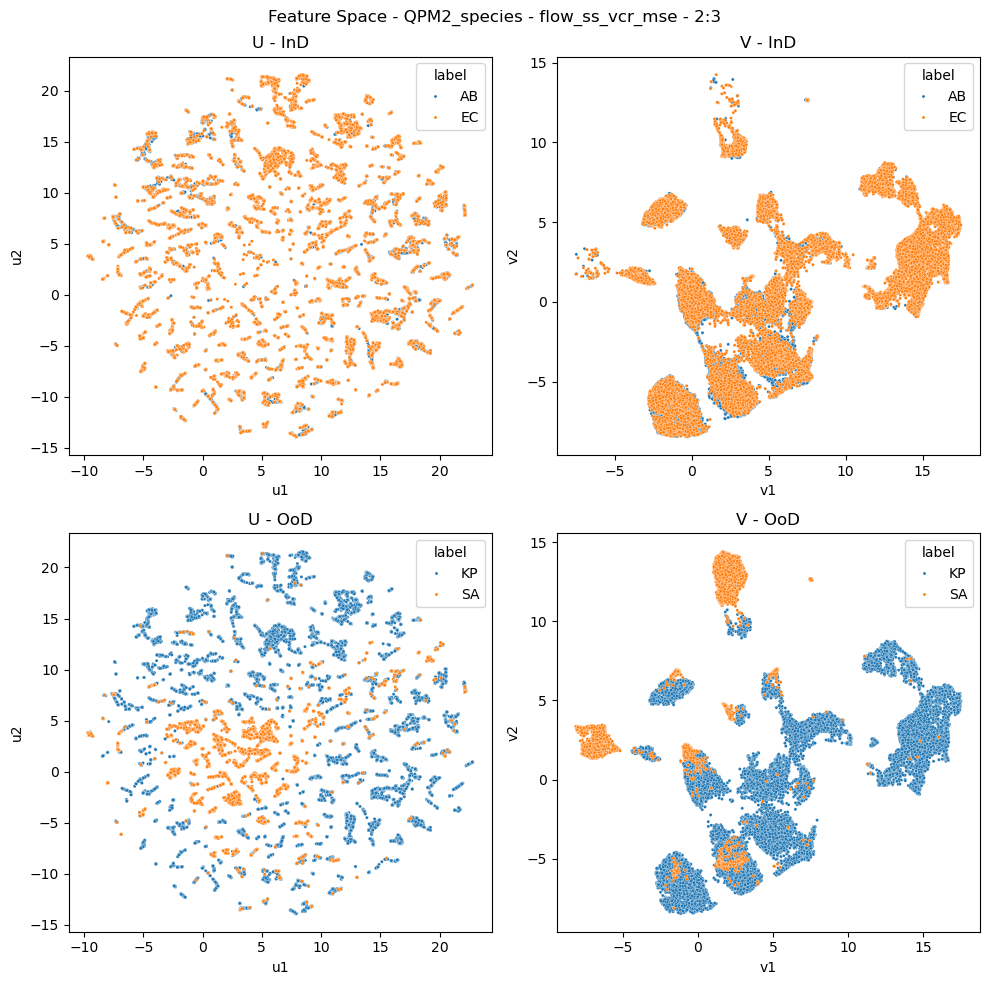

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

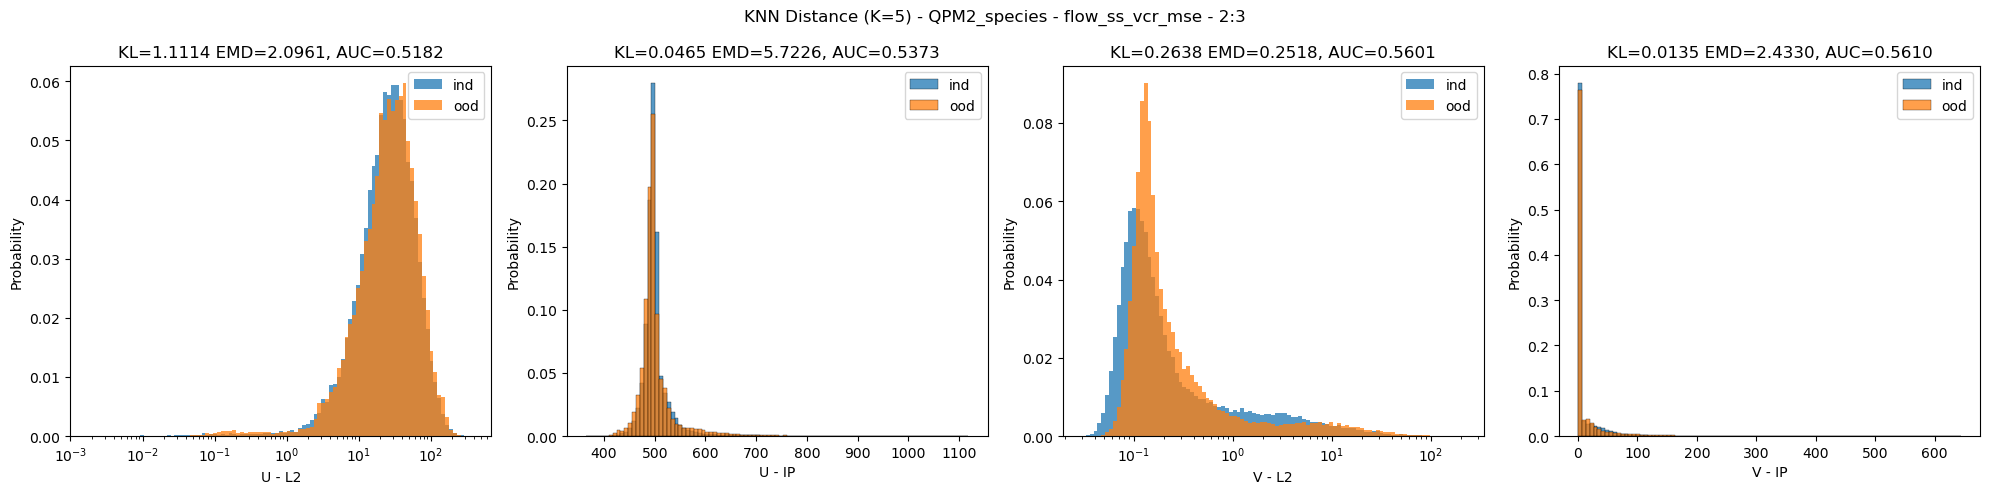

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

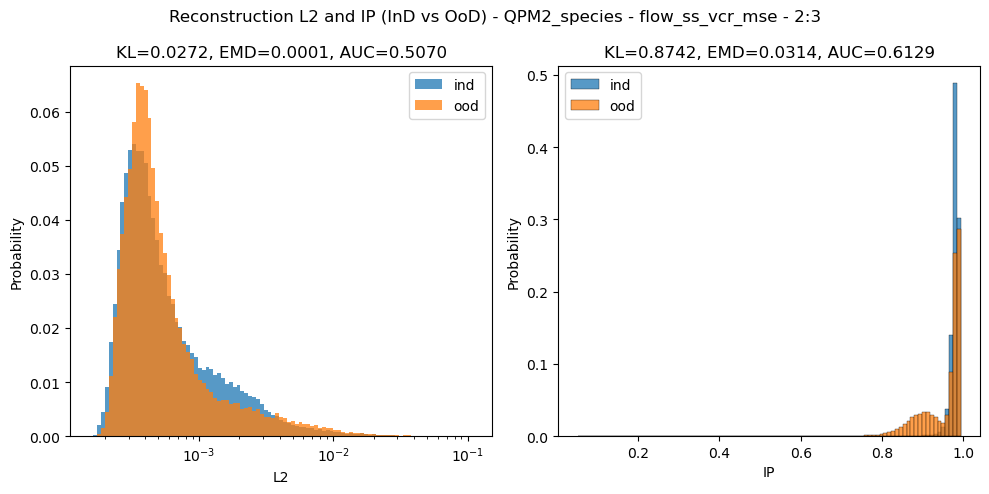

In [14]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)


# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)

if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)

run_stats["norm_u"] = dict(val_data=val_n_u.tolist(), ind_data=ind_n_u.tolist(), ood_data=ood_n_u.tolist() if ood_str else None)
run_stats["norm_v"] = dict(val_data=val_n_v.tolist(), ind_data=ind_n_v.tolist(), ood_data=ood_n_v.tolist() if ood_str else None)

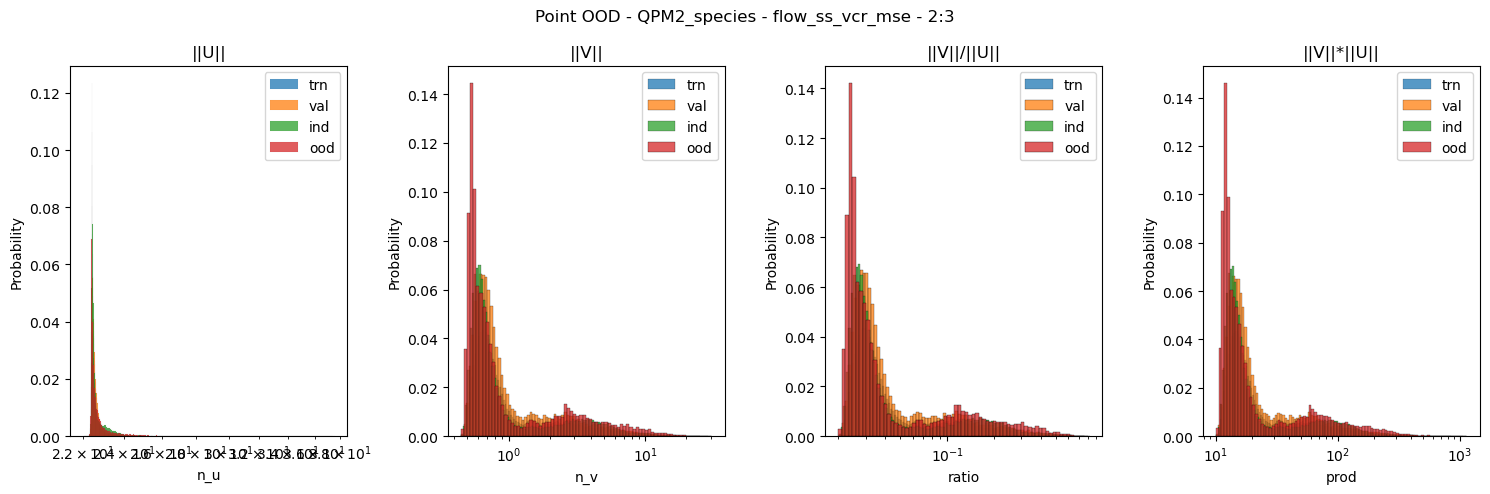

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


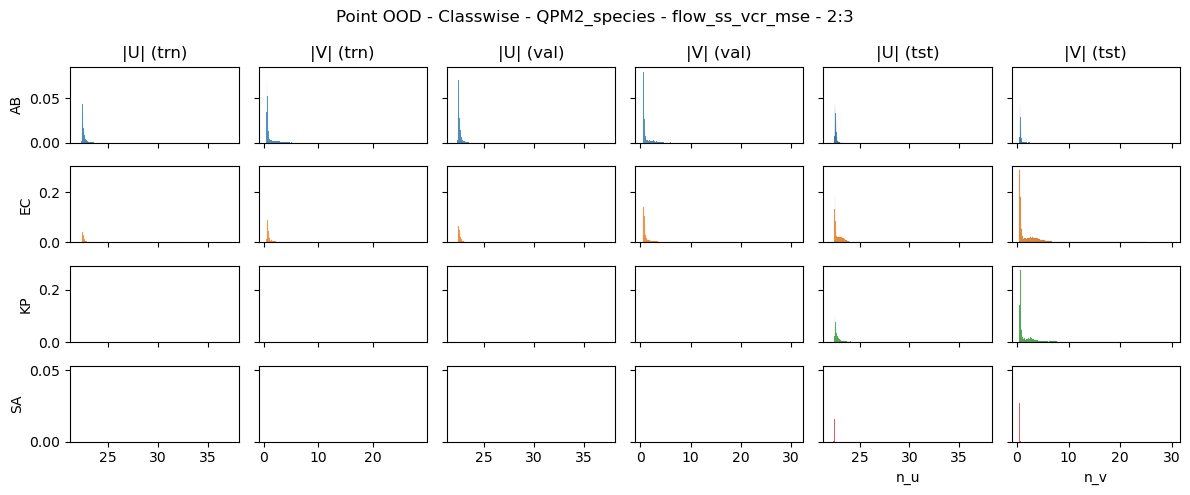

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

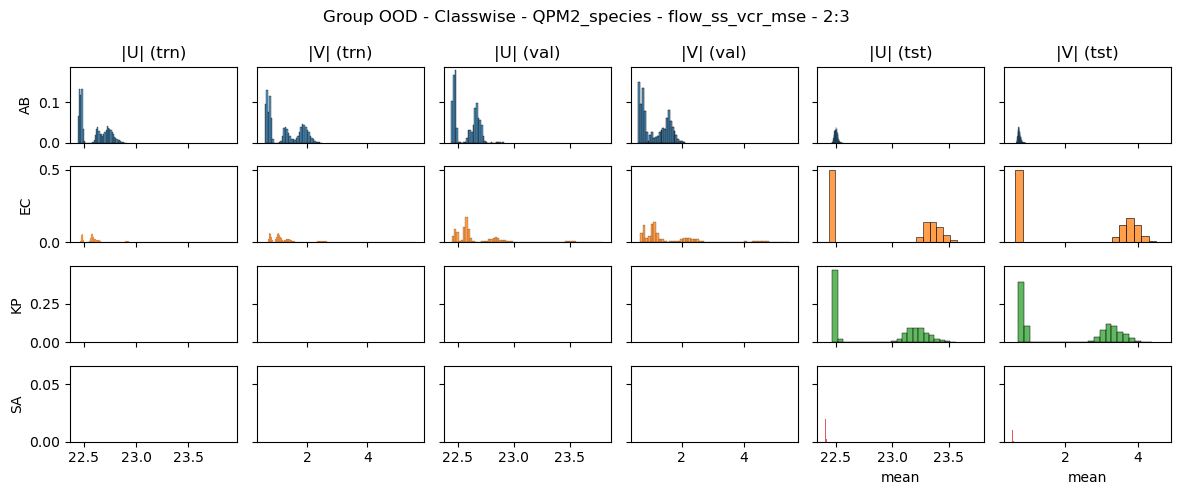

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)